<a href="https://colab.research.google.com/github/fannyg08/Econometrie/blob/main/Projet_Econom%C3%A9trie_versionfinale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**ECONOMETRIE DES SERIES TEMPORELLES**

> *Letaconnoux Lauryn et Gauducheau Fanny*



**Plan d'étude :**

* **Partie 1 : Modèle univarié**
 * Choix et importation des données
   * Importation des données
   * Statistiques descriptives des séries
 * Représentation graphique et autocorrélogrammes simples et partiels des séries
   * Cours du blé
   * Heating Degree Days
 * Application de la stratégie de test de racine unitaire
   * Tests ADF, KPSS et PP sur le cours du blé
   * Tests ADF et KPSS sur les HDD
 * Estimation du modèle ARMA
   * Test de signifaticativité des coefficients
   * Test d'ajout des retards
   * Test sur les résidus
 * Graphique combinant les séries
 * Calcul des prévisions sur les horizons de 1 à 3
 * Estimation du modèle de GARCH
* **Partie 2 : Modèle multivarié**
 * Estimation du modèle VAR
 * Observation des possibles relation de causalité entre les variables
 * Analyse Impulsion-Reponse
* **Conclusion générale**
* Bibliographie


# Partie 1: Modélisation Univariée

## 1. Choix et importation des données



Le blé est la deuxième céréale la plus consommée au monde, après le riz. On le retrouve dans toutes les cuisines et habitudes alimentaires européennes surtout, mais aussi asiatique, nord-africaines et américaines. Avec la croissance de la population mondiale incessante, la demande de ce dernier ne cesse d'augmenter pour atteindre près de 800 millions de tonnes sur l'année 2023 d'après le rapport WADE du Ministère de l'Agriculture Américain. Le pays est très impliqué dans le suivi de l'offre et la demande, car il est l'un des principaux producteurs, derrière la Chine et l'Inde, avec plus de 60 millions de tonnes produites annuellement.  

La culture de cette céréale est, comme toutes les autres, sujette aux conditions météorologiques. Les Etats-Unis profitent de leurs millions d'hectares de champs, et d'un climat plutôt clément, qui les a béni en terme d'agriculture. Or, depuis déjà les années 1970, ce sont des centaines de milliers de chercheurs, scientifiques, économistes, activites et politiciens qui alertent sur le dérèglement climatique. Un phénomène qui ne cesse de multiplier les épisodes de températures extrêmes et catastrophes naturelles(peut-être placer un ou 2 exemples).

Si l'économie s'intéresse à l'allocation des ressources entre les agents, alors comment cette dernière est-elle influencée par le climat ? Comme la question englobe de nombreuses problématiques, nous avons décidé de nous concentrer sur la céréale préférée des Français, mais d'étudier des données Américaines car ces dernières sont plus complètes.

Comme tous les prix, le cours du blé se défini grâce à la rencontre de l'offre et de la demande. Meilleure est la production, meilleur est le prix pour le consommateur. Mais en cas de mauvaise récolte, le blé devient cher.

En ce qui concerne les données météorologiques, nous avons choisi d'utiliser les Daily Heating Degree Days : une mesure spécifique de la température relative à un niveau donné, sur une période et une zone données.
Cela permet de déterminer à quel point un jour est chaud ou froid, comparé à une moyenne. Donc plus les températures sont extrêmes, plus il faut compter de Heating Degree Days (HDD). Aux Etats-Unis, la température standard (donc la moyenne de comparaison) est 65 degrés Farenheit, ce qui correspond à environ 18°Celcius.


Nous commençons par importer les données du cours du blé, depuis le site www.macrotrends.net
Pour les données des HDD, nous avons utilisé le site https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/cdus/degree_days/.

####Instalation des packages

In [ ]:
#Installation des packages

#install.packages('data.table')
install.packages('ggplot2')
#install.packages('urca')
#install.packages('lmtest')
#install.packages('sandwich')
install.packages('reshape')
#install.packages('TT')
#install.packages('quantmod')
install.packages('readr')
#install.packages('forecast')
#install.packages('dplyr')
install.packages('stringr')
install.packages('FinTS')

results='hide'

####**Import des données cours du blé**

Nous commençons par récuperer les données sur un fichier csv, qui est ensuite mis en public sur un Google Drive.
Après import, nous avons décidé de travailler avec des données mensuelles. Or, nous avions jusqu'à présent des cours journaliers. Il a donc fallu regrouper les données par mois, puis faire une sorte de moyenne.

In [ ]:
library(ggplot2)
library(reshape)
library(curl)
library(stringr)

#On récupère les données sur le prix du blé à l'aide d'un fichier csv enregistré sur google drive
#le fichier est tiré du site : "https://www.macrotrends.net/2534/wheat-prices-historical-chart-data"
id <- "1l2gKYQGdM7ddk6dfjolZNHxiTYpA_lHm"
sURL <- sprintf("https://docs.google.com/uc?id=%s&export=download", id)
connexion <- curl(sURL)
wheat_data <- read.csv(connexion, header = TRUE, sep = ",", dec = ".")
wheat_data<-data.frame(wheat_data["date"],wheat_data["value"])
colnames(wheat_data)<-c("Date","Price")

#wheat_data$Date
#wheat_data$Price

x <-c()
y <-c()
#On retranche les données pour avoir celles entre 2000 et 2023, et ont fait une moyenne sur les données par mois
i=1
while (strtoi(substr(wheat_data$Date[i],1,4))<2023){ #On boucle sur les données jusqu'en 2022
  if (strtoi(substr(wheat_data$Date[i],1,4))>1999){ #On s'assure que les données soient après 1999
    j <- substr(wheat_data$Date[i],6,7)
    sum <- 0
    compt <- 0
    while (substr(wheat_data$Date[i],6,7)==j){
      sum <- sum + wheat_data$Price[i]
      compt <- compt + 1
      i <- i + 1
    }
    sum<-sum/compt #Pour obtenir une moyenne
    #on met les dates au format date pour les graphiques
    x <- append(x, as.Date(str_c(substr(wheat_data$Date[i], 1, 7),'-01')))
    y <- append(y, sum)
  } else {i<-i+1}
}
wheat_data_df<-data.frame(x,y)
colnames(wheat_data_df)<-c("Date","Price")

Puis nous importons les données concernnat les Heating Degree Days (HDD).
On se concentre sur les données au Kansas, l'un des états les plus producteurs de blé.
Ces données sont également journalières, nous les avons mensualisées avec la même méthode que pour le cours du blé.
Le code fait une boucle sur les années contnues dans le vecteur "annees", afin de mettre à jour le lien qui donne accès aux données des HDD.

In [ ]:
library(readr)

lien <- "https://ftp.cpc.ncep.noaa.gov/htdocs/degree_days/weighted/daily_data/"
annees <- c("2000","2001","2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015","2016","2017","2018","2019","2020","2021","2022")
jours_par_mois <- c(31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31)
annees_bisextiles <- c(2000, 2004, 2008, 2012, 2016, 2020)
vect_dates <- c()
vect_HDD <- c()

for (i in 1:length(annees)) { #Boucle sur les années
  lien_ <- paste(lien,annees[i],"StatesCONUS.Heating.txt",sep="/") #Récupération du lien correspondant à l'année 2000+i
  data_annee <- read_delim(lien_, delim="|", col_names=FALSE, skip=3) #Récupération des données grace au lien
  data_annee <- t(data_annee) #On transpose les données pour faciliter la suite
  data_annee<-data.frame(data_annee) #On met les données au format data frame car il sera plus simple d'extraire les valeurs souhaitées
  track <- 2 #On initialise un compteur qui sera u, témoin pour savoir où on se situe dans l'année pour extraire les données (on commence à 2 pour ne pas prendre la données "KS")

  for (j in 1:length(jours_par_mois)) { #Boucles sur les mois
    vect_dates <- append(vect_dates, as.Date(str_c(annees[i], '-', j, '-01'))) #On reseigne le mois pour lequel on récupère les données dans vect_dates

    if (j == 2 && annees[i] %in% annees_bisextiles) { #Si le mois en question est février et que l'année est bisextile alors le mois en cours comporte 29 jours
      vect_HDD <- append(vect_HDD, mean(as.integer(data_annee[track:(track+jours_par_mois[j]),15]))) #On ajoute un jour (-1+1=0)
      track <- track + jours_par_mois[j] + 1 #On ajoute un jour de plus dans le traceur
    } else {
      vect_HDD <- append(vect_HDD, mean(as.integer(data_annee[track:(track+jours_par_mois[j]-1),15]))) # Dans la 15e colonne on etrait autant de données de que nombre de jours dans le mois, on met les données du vecteur récupéré au format integer et on en fait la moyenne
      track <- track + jours_par_mois[j]
    }
  }
}

# Impression des résultats
HDD_data_df <- data.frame(Date = vect_dates, HDD = vect_HDD)
colnames(HDD_data_df)<-c("Date","HDD")
#HDD_data_df

####**Statistiques descriptives des séries**

**Cours du blé:**

In [ ]:
library(FinTS)

des_wheat<- FinTS.stats(wheat_data_df$Price)
des_wheat

Warning message in FinTS.stats(wheat_data_df$Price):
“requires(e1071) for skewnessand kurtosis; returning NAs”


Start,Size,Mean,Standard.Deviation,Skewness,Excess.Kurtosis,Minimum,Maximum
<int>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>
1,276,5.287411,1.940338,NA,NA,2.417913,11.45405


Notre échantillon a une taille n=276, avec une moyenne de $5.3 sur 22 ans.

In [ ]:
library(FinTS)

des_HDD <- FinTS.stats(HDD_data_df$HDD)
des_HDD

Warning message in FinTS.stats(HDD_data_df$HDD):
“requires(e1071) for skewnessand kurtosis; returning NAs”


Start,Size,Mean,Standard.Deviation,Skewness,Excess.Kurtosis,Minimum,Maximum
<int>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>
1,276,13.33911,13.14203,NA,NA,0,42.25806


En moyenne, le nombre de Heating Degree Days est de 13.34 par mois. Cela signifique que la température moyenne aux Etats-Unis dévie de 13°F autour de la température de référence. En d'autre termes, elle oscille entre 51.7°F (11°C) et 78.3°F (25°C)(autour du 65°F, qui correspond à 18°C).
Cela permet d'observer l'intensité des température, et l'amplitude de la variation autour d'une moyenne.

##2. Représentation graphique et autocorrélogrammes simples et partiels des séries

####a. Cours du blé

Loading required package: xts

Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



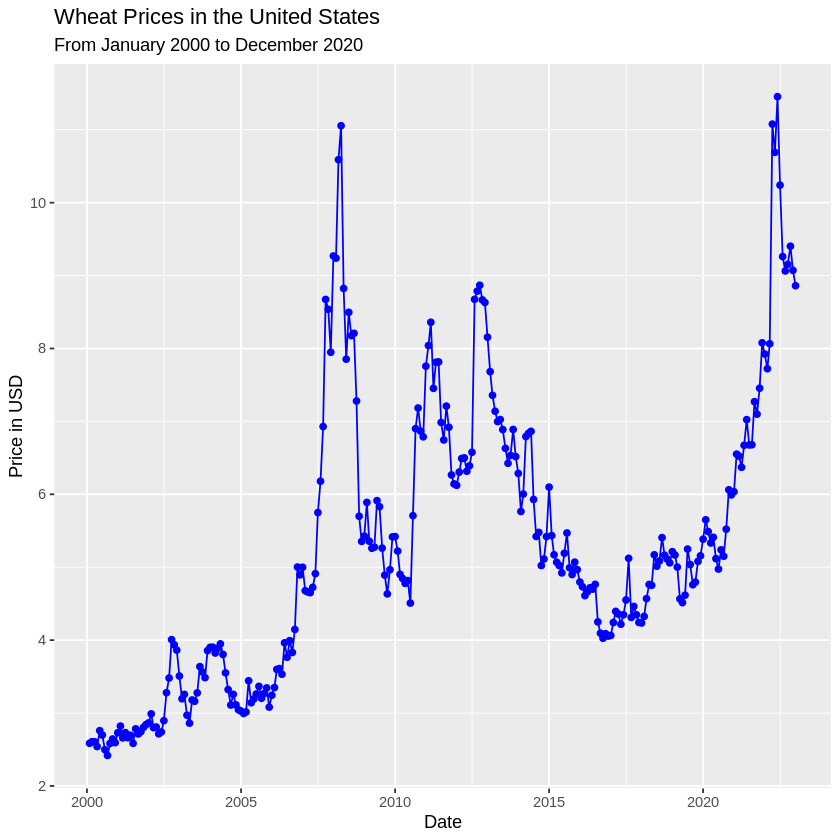

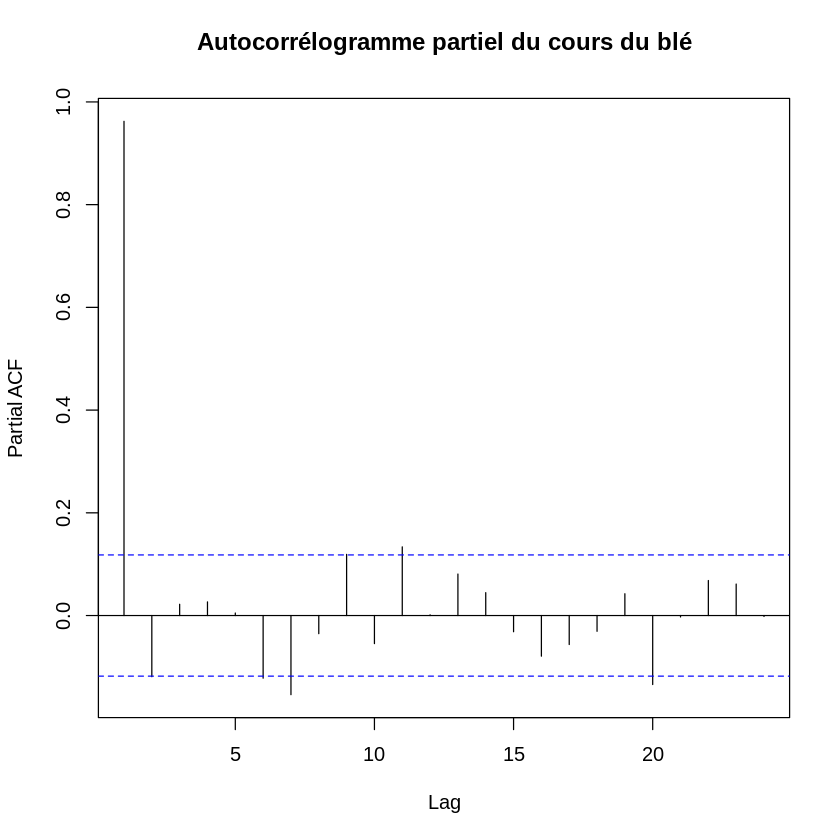

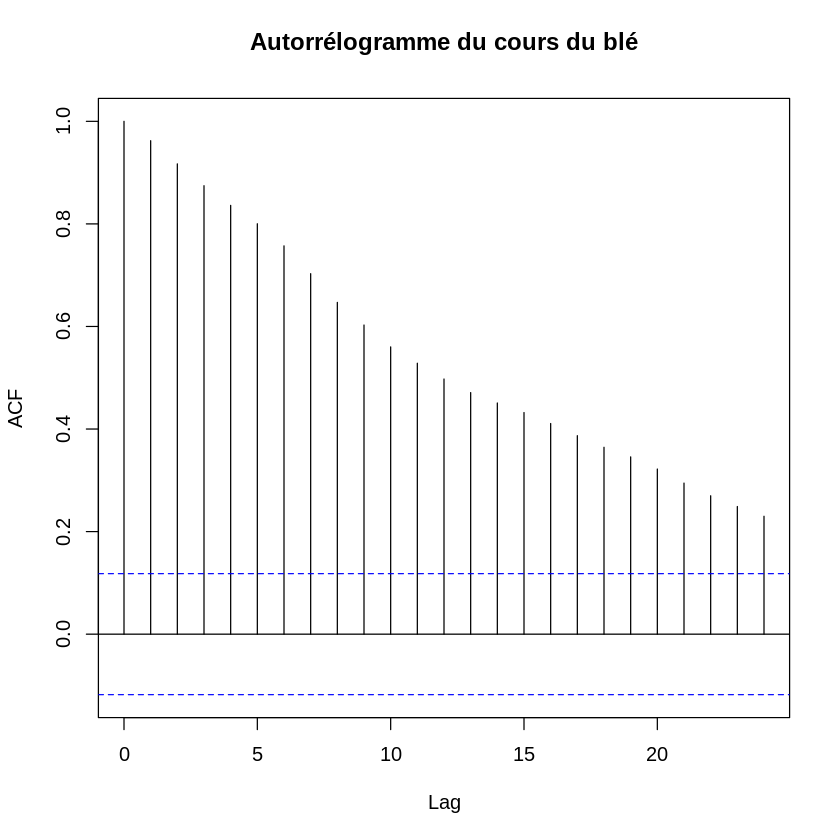

In [ ]:
#Représentation graphique et autocorrélogrammes simples et partiels du cours du blé aux US
library(TT)
library(quantmod)
library(ggplot2)

#Représentation graphique du cours du blé
graph_wheat_data<-ggplot(data=wheat_data_df,aes(x=Date,y=Price))+geom_point(color='blue')+geom_line(color='blue')
graph_wheat_data+labs(x = "Date", y = "Price in USD", title = "Wheat Prices in the United States", subtitle = "From January 2000 to December 2022")

#Calcul des Autocorrélations et Autocorrélations partielles
wheat_pacf <-pacf(wheat_data_df$Price,main="Autocorrélogramme partiel du cours du blé")
wheat_acf<- acf(wheat_data_df$Price,main="Autorrélogramme du cours du blé")

**Cours du blé et taux de rendements: des crises alimentaires à répétition** \\
En observant les graphiques, nous remarquons une très forte augmentation du cours du blé vers 2007-2008. Cela est un résultat direct de la crise alimentaire mondiale de 2007-2008, qui a eu un impact sur la planète entière. De nombreuses causes lui sont attribuées comme la diminution de sols arables ou la démographie changeante.\
Effectivement, comme le montre le premier graphique, entre 2000 et 2005, le prix du blé augmentait progressivement, comme de nombreux économistes l'avait prédit, résultat d'un ré-ajustement des prix des matières premières alimentaires, après une trentaine d'années très stable.\
Dès 2006, le cours du blé a commencé à augmenter drastiquement, et ce à cause des stocks qui ne faisaient que diminuer, notamment dû à l'impossibilité pour les agriculteurs de suivre la nouvelle cadence démographique.\
En outre, avec la croissance démographique, et l'augmentation de la taille de la classe moyenne dans de nombreux pays en développement (comme la Chine***), les habitudes alimentaires ont été boulversées. La consommation de viande et de produits d'origine animale n'a fait que croître, mettant alors la pression sur la production de blé, riz et autres céréales, afin de nourrir non seulement les humains mais aussi le bétail.
De plus, la quantité de sols arables, autrements dit de terres cultivables, n'a fait que baisser: l'appauvrissement de la qualité des sols lié à une activité agricole trop intense a commencé à montrer ses conséquences négatives.

Enfin, sécheresses, hivers rudes et inondations n'ont pas aidé la production de blé dans le milieu des années 2000.

En 2012, nouveau pic du cours du blé. Une explication climatique est ici privilégiée pour les Etats-Unis: une année particulièrement chaude, qui a fortement impacté les récoltes... de maïs. Or, si les agriculteurs ne peuvent plus compter sur le maïs, il faut remplacer la céréale par une autre: le blé, qui lui, a beaucoup moins souffert. Une telle croissance de la demande ne fait qu'emmener les prix proche des sommets de 2007.

**Etude de l'autocorrélogramme et l'autocorrélogramme partiel** \\
L'autocorrélogramme présente une décroissance très progressive. Quant à l'autocorélogramme partiel, celui-ci présente deux pics significatifs, avant une chute brutale.
De ce fait, la série ressembble beaucoup à un AR(2), et peut s'écrire de la forme :\
\
$$
\phi(B)X_t = \varepsilon_t
$$\
Avec $(\varepsilon_t)_t$ une série de bruits blancs faibles et $\phi(B) = 1- \phi_1B -\phi_2B^{2}$ et $\phi_2 \neq 0$.\
\
Par un résultat du cours on est sait alors que la série corrigée est inversible, mais pas nécessairement stationnaire. On étudiera sa stationnarité à la section suivante à l'aide des test de Dickey-Fuller augmentés (ADF) et KPSS.\
En observant le premier graphique, on peut néanmoins déjà supposé que la série n'est pas stationnaire.


####b. Heating Degree Days

**Représentation et autocorrélogrammes des données brutes**


Attaching package: ‘forecast’


The following object is masked from ‘package:FinTS’:

    Acf




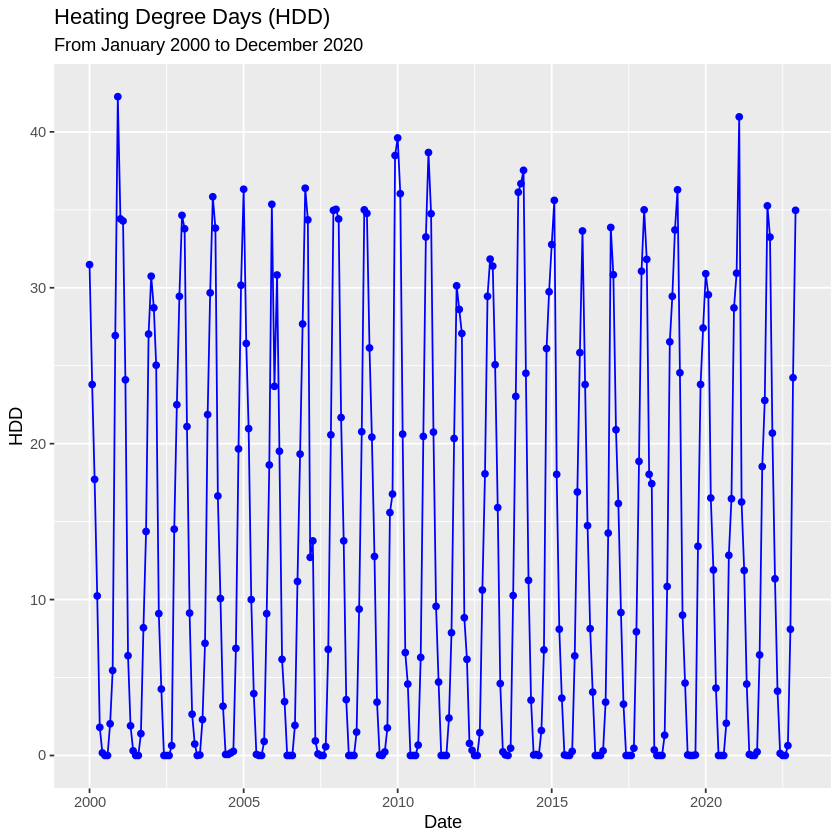

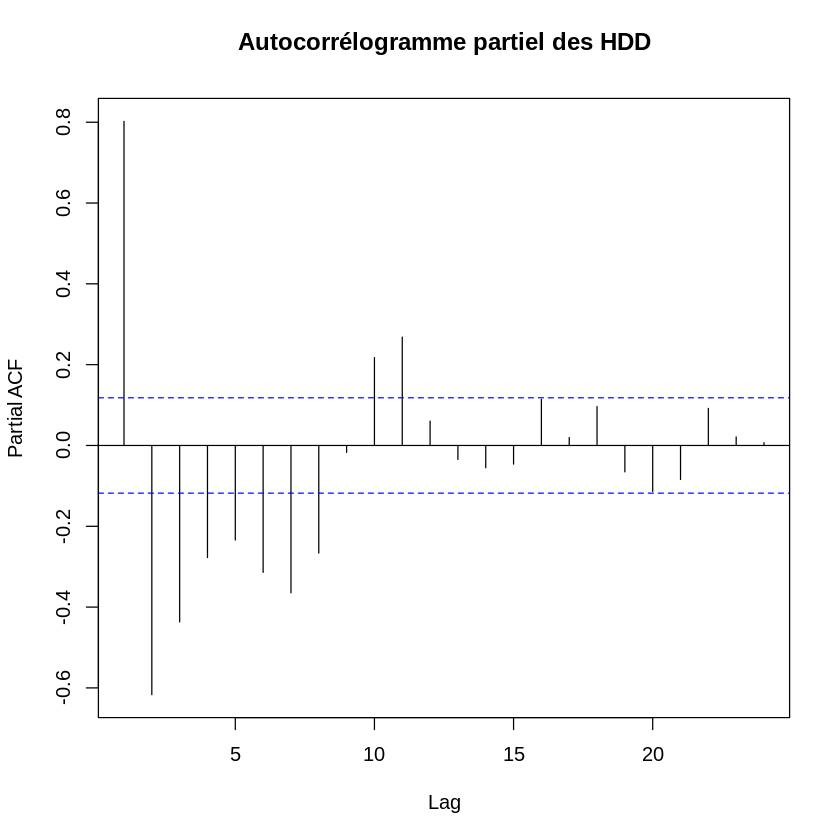

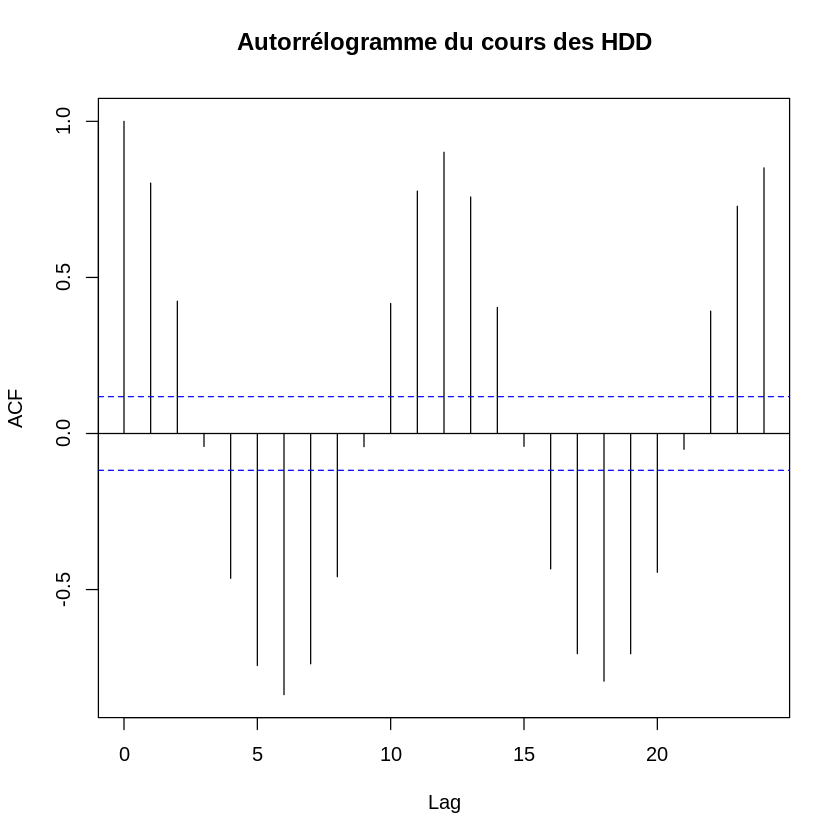

In [ ]:
#Représentation graphique et autocorrélogrammes simples et partiels des HDD
library(ggplot2)
library(forecast)

#Représentation graphique du cours du blé
graph_HDD_data<-ggplot(data=HDD_data_df,aes(x=Date,y=HDD))+geom_point(color='blue')+geom_line(color='blue')
graph_HDD_data+labs(x = "Date", y = "HDD", title = "Heating Degree Days (HDD)", subtitle = "From January 2000 to December 2022")

#Calcul des Autocorrélations et Autocorrélations partielles
HDD_pacf <-pacf(HDD_data_df$HDD,main="Autocorrélogramme partiel des HDD")
HDD_acf<- acf(HDD_data_df$HDD,main="Autorrélogramme du cours des HDD")

**Représentation et autocorrélogrammes des données corrigées de leur saisonnalité**\
\
Correction de la saisonalité :
* On observe une saisonnalité très marquée à laquelle on pouvait s'attendre pour des données météorologiques rythmées par les saisons.
* Afin de pouvoir travailler avec ces données, il a donc été nécessaire de les corriger à l'aide de la fonction *decompose* de R
* La fonction décompose la série qu'elle prend en argument, elle la décompose par sa tendance, sa saisonnalité et son aléa
* Ainsi, pour corrigé la série de sa saisonnalité on lui retire  à l'aide de la ligne : *serie_temporelle-decomposition$seasonal*


Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Warning message:
“Removed 12 rows containing missing values (`geom_line()`).”


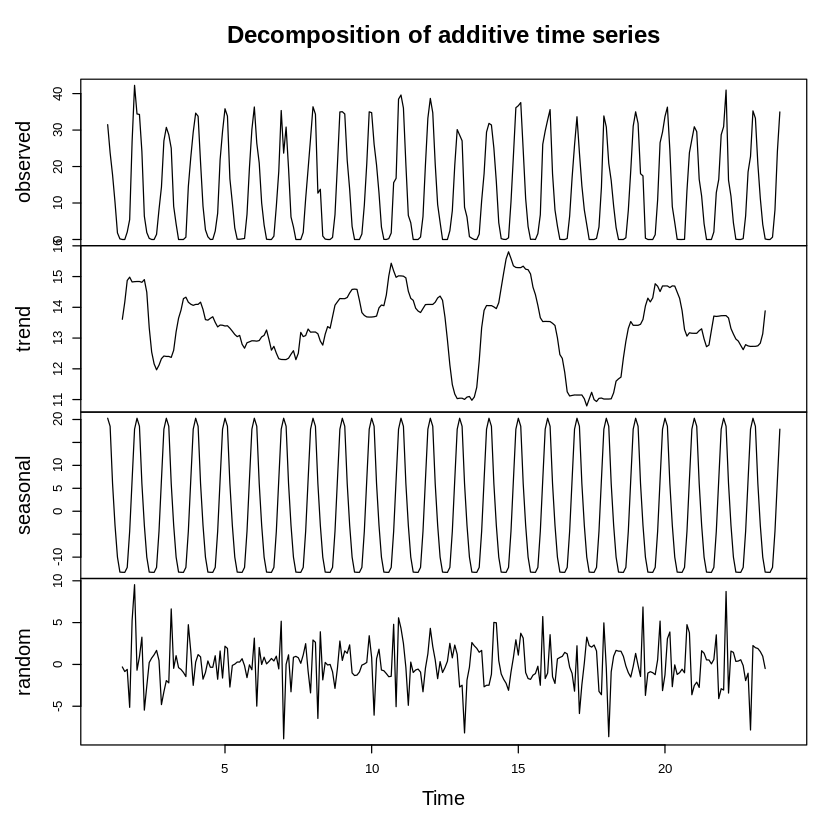

Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


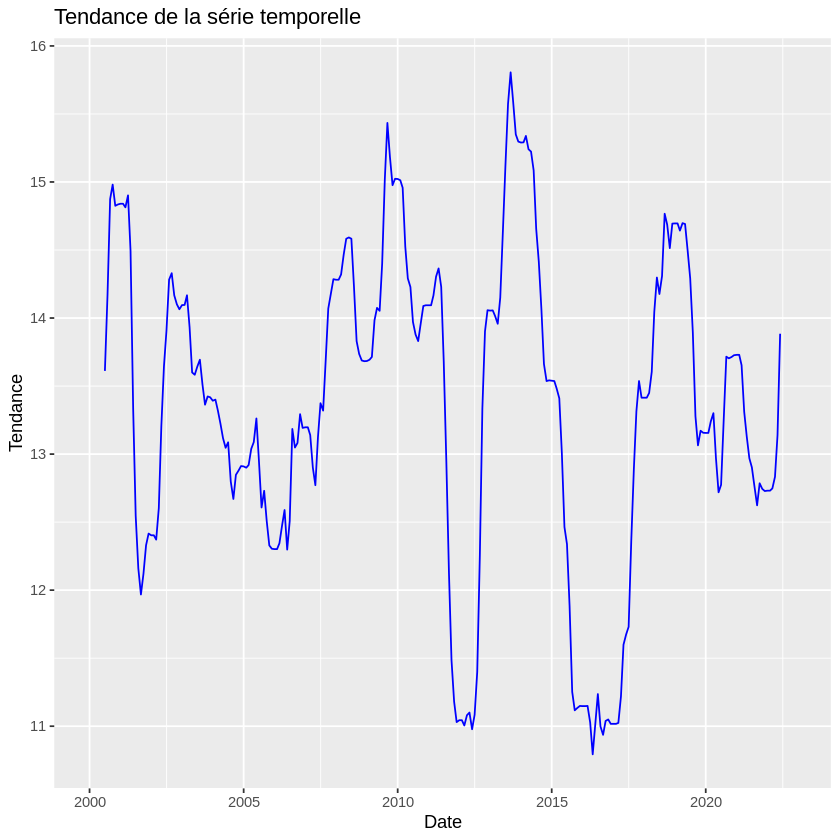

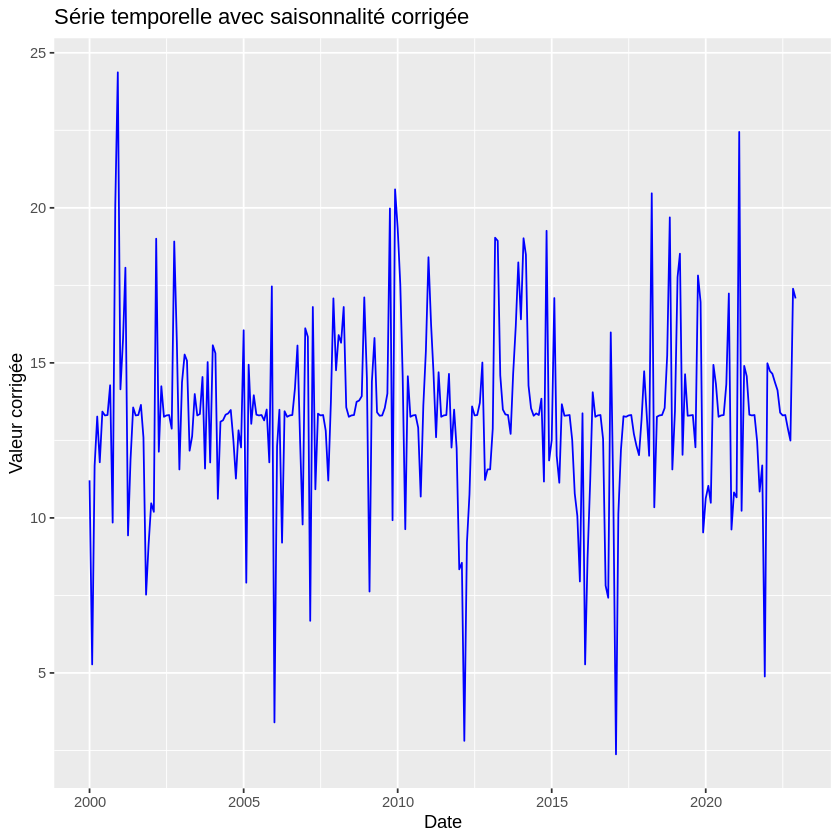

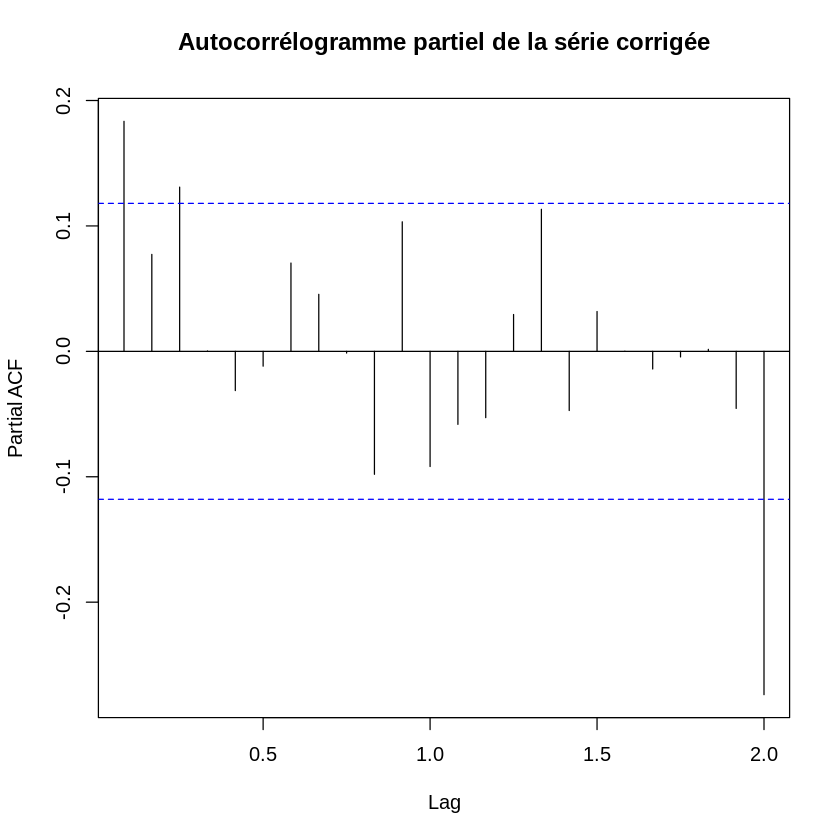

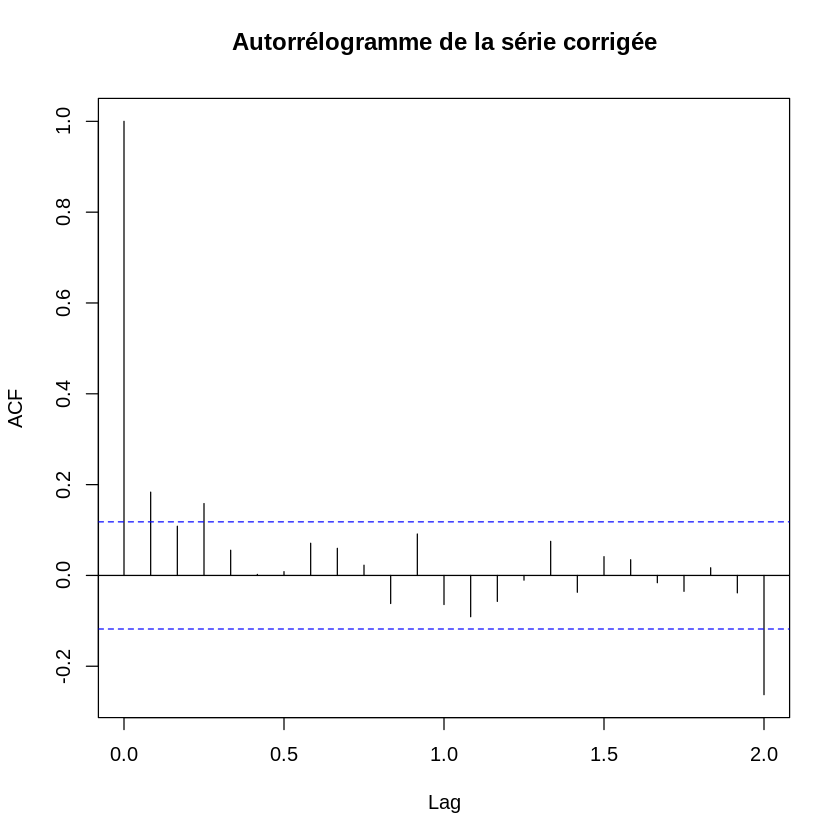

In [ ]:
#correction de la saisonalité
# On crée une série temporelle à partir des données
serie_temporelle <- ts(HDD_data_df$HDD, frequency = 12)  # fréquence annuelle

# On décompose la série temporelle pour extraire la composante saisonnière
decomposition <- decompose(serie_temporelle)
plot(decomposition)

# On accéde à la composante saisonnière corrigée
HDD_data_c <- serie_temporelle - decomposition$seasonal
ggplot() +
  geom_line(aes(x = HDD_data_df$Date, y = decomposition$trend), color = 'blue') +
  labs(x = "Date", y = "Tendance", title = "Tendance de la série temporelle")

# On crée un nouveau graphique pour visualiser la série corrigée
ggplot() +
  geom_line(aes(x = HDD_data_df$Date, y = HDD_data_c), color = 'blue') +
  labs(x = "Date", y = "Valeur corrigée", title = "Série temporelle avec saisonnalité corrigée")

#Calcul des Autocorrélations et Autocorrélations partielles de la série corrigée
HDD_pacf <-pacf(HDD_data_c,main="Autocorrélogramme partiel de la série corrigée")
HDD_acf<- acf(HDD_data_c,main="Autorrélogramme de la série corrigée")

**Interprétation des graphiques**

Les HDD sont une série de données très saisonnière. Cela est totalement logique, car ils correspondent aux degrés en plus/moins par rapport à un indicateur. En fonction des saisons, les HDD varient et s'éloignent plus ou moins des 18°C de seuil de référence.

**Autocorrélogramme classique et partiel**

Nous observons que l'autocorrélogramme et l'autocorrélogramme partiel des HDD ont une forme sinusoïdale lorsque la série n'est pas corrigée de sa saisonnalité. Cette forme caractéristique demeure une fois la série corrigée, mais elle est moins prononcée.
Cela permet de déduire que les racines des polynomes $\phi$ et $\theta$ de la partie AR et MA sont complexes. Aussi, cette forme n’est pas un hasard : elle peut être interprétée comme l'illustration la saisonnalité de la série. Puisque les HDD sont directement liées à la météo ainsi qu’au cycle des saisons, on distingue des motifs récurrents. Les écarts de la température de référence sont bien plus importants en été et en hiver, tandis qu’à l’automne et au printemps, le mercure gravite autour des 18°C, ce qui signifie que les variations sont bien moindres.


En observant les deux ACF et PACF, nous remarquons que la significativé chutte brutalement à chaque fois. On peut donc faire l'hypothèse, au vu des graphiques, que la série des HDD peut être un ARMA(3,2).

On a alors que la série $Y_t$ du nombre de HDD peut s'écrire de la forme :\
\
$$
\phi(B)Y_t=\theta(B)\varepsilon_t\ ,\
$$
\
Avec
$(\varepsilon_t)_t$ une série de bruits blancs faibles et :
$$\left\{ \begin{array}{c}
\phi(B) = 1- \phi_1B -\phi_2B^{2} -\phi_3B^{3}\ et\ \phi_3 \neq 0\\
\theta(B) = 1- \theta_1B -\theta_2B^{2}\ et\ \theta_2 \neq 0 \end {array}
\right.
$$
Dans le cas d'une série de type ARMA, on ne peut rien affirmer sur sa stationnarité ou son inversibilité.\
En suppsosant que les polynômes $\phi$ et $\theta$ n'aient pas de racines communes et que la variances des $\varepsilon_t$ soit strictement positive, pour avoir :
* la staionnarité : il faut que le polynôme $\phi$ ait toutes ses racines dans le cercle unité
* l'inversibilité : il faut que le polynôme $\theta$ ait toutes ses racines dans le cercle unité

Nous n'avons pas déterminé les coefficients de ces polynômes, on ne peut donc pas déterminer si oui ou non les racines sont dans le cercle unité.\
Pour la suite de l'étude nous avons uniquement besoin des informations sur la stationnarité, pour cela nous allons procéder aux test ADF et KPSS comme pour la série du cours du blé.





##3. Application de la stratégie de test de racine unitaire à chaque série

###Tests sur le cours du Blé (wheat_data_df)

####Tests de Dickey Fuller

Il est nécessaire de tester la stationnarité des séries afin de pouvoir travailler avec. Si elles ne le sont pas, il faudra alors effectuer des transformations, qui varient en fonction de la forme de la série.
Il existe de nombreux tests, détaillés ci-dessous.

Le premier test est celui de **Dickey-Fuller**.
Les hypothèses du test sont les suivantes:

$$\left\{ \begin{array}{c}
H_0: \phi_1 = 1 \Leftrightarrow \rho=0 \\
H_1: \vert \phi_1 \vert < 1 \Leftrightarrow \rho<0 \end {array}
\right.  , avec :\rho  = \phi_1 - 1.$$  

Dans le cas où l'on rejette $H_0$, cela signifie que la série est stationnaire. C'est a dire que la racine n'est pas unitaire mais "explosive".
Ensuite, la statistique de test est:

$$ t_\rho = \frac{\hat{\rho}}{\sigma_\hat{\rho}} $$

Lorsque $t_\rho < t$ avec t le seuil issu de la table de Dickey-Fuller (DF), on rejette $H_0$.

Il y a trois niveaux de test, effectués sur des modèles de plus en plus spécifiques:
- avec constante et tendance déterministre (DF1)
- avec constante uniquement (DF2)
- sans constante ni tendance déterministe (DF3)

L'interprétation des résultats se fera de la manière suivante :
- Si le test DF rejette l'hypothèse nulle : On peut conclure que la série est stationnaire.
- Si le test DF ne rejette pas l'hypothèse nulle et que le test KPSS rejette l'hypothèse nulle : La série a une tendance déterministe et peut nécessiter une différenciation pour la rendre stationnaire.
- Si les deux tests ne rejettent pas l'hypothèse nulle : La série peut nécessiter une transformation supplémentaire (par exemple, log, racine carrée) pour devenir stationnaire.


Pour ce qui est du retard p (lag), nous avons choisi p=15, au vu de la taille de notre échantillon.
On part du test le plus global (avec constante et tendance) au plus précis (sans constante ni tendance).

#####Test DF1

In [ ]:
#TEST DF 1: sans constante, ni tendance déterministe (type= c("none"))
library(urca)

adf1<-ur.df(y = wheat_data_df$Price,type=c("none"), lag=15, selectlags = c('AIC'))
summary(adf1)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.92125 -0.19412 -0.01343  0.17531  2.98775 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
z.lag.1      0.001200   0.005249   0.229   0.8194  
z.diff.lag1  0.113557   0.062758   1.809   0.0716 .
z.diff.lag2 -0.048087   0.063158  -0.761   0.4471  
z.diff.lag3 -0.022156   0.062936  -0.352   0.7251  
z.diff.lag4 -0.037886   0.062776  -0.604   0.5467  
z.diff.lag5  0.096295   0.062763   1.534   0.1262  
z.diff.lag6  0.097134   0.063447   1.531   0.1270  
z.diff.lag7 -0.051033   0.064586  -0.790   0.4302  
z.diff.lag8 -0.138286   0.064682  -2.138   0.0335 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4641 on 251 degrees of freedom
Multiple

#####Test DF 2: avec constante et sans tendance


In [ ]:
library(urca)
adf2<- ur.df(y = wheat_data_df$Price,type=c("drift"), lag=15, selectlags = c('AIC'))
summary(adf2)



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.91768 -0.21201 -0.06428  0.16090  3.03407 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.239741   0.092471   2.593   0.0101 *
z.lag.1     -0.041366   0.016456  -2.514   0.0126 *
z.diff.lag1  0.135572   0.062454   2.171   0.0309 *
z.diff.lag2 -0.042684   0.063060  -0.677   0.4991  
z.diff.lag3 -0.008534   0.062955  -0.136   0.8923  
z.diff.lag4 -0.009632   0.062857  -0.153   0.8783  
z.diff.lag5  0.123446   0.062597   1.972   0.0497 *
z.diff.lag6  0.125709   0.063620   1.976   0.0493 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4622 on 252 degrees of freedom
Multiple R-squared:  0.06897,	Adjusted R-squared:  0.04311 

#####Test DF 3 (avec constante et tendance)

In [ ]:
library(urca)
adf3<- ur.df(y = wheat_data_df$Price,type=c("trend"), lag=15, selectlags = c('AIC'))
summary(adf3)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.81785 -0.21611 -0.05206  0.16588  2.98716 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.2195023  0.0931100   2.357  0.01917 * 
z.lag.1     -0.0563344  0.0189958  -2.966  0.00331 **
tt           0.0006904  0.0004414   1.564  0.11904   
z.diff.lag1  0.1417380  0.0624001   2.271  0.02397 * 
z.diff.lag2 -0.0347794  0.0630829  -0.551  0.58190   
z.diff.lag3 -0.0016774  0.0629284  -0.027  0.97876   
z.diff.lag4 -0.0032693  0.0628094  -0.052  0.95853   
z.diff.lag5  0.1290051  0.0625190   2.063  0.04010 * 
z.diff.lag6  0.1325471  0.0635884   2.084  0.03813 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4609 on 251 d

#####Interprétation des résultats des 3 tests Dickey Fuller


Le dernier test (DF1) est le plus global, nous partons donc d'un modèle *sans constante ni tendance déterministe*. Avec 15 retards, la série n'est **pas stationnaire**. Effectivement, la p-value est supérieure à 0.05, qui correspond au seuil d'erreur de 5%. Le choix de 15 retards est lié à la taille de l'échantillon (bien supérieur à 100).

Les deux autres tests, de plus en plus précis, avec ajout d'une constante puis d'une tendance déterministe, concluent de la même façon. Effectivement, les p-value sont supérieures au seuil de 0.05. Donc nous ne rejettons pas l'hypothèse nulle de non-stationnarité autour d'une racine unitaire.

Cependant, la littérature relève des limites au test de Dickey Fuller: nous supposons que la série ne change pas sur toute la période étudiée pour l'hypothèse $H_0$. Or, il est possible que celle-ci soit impactée par des chocs. Dans notre cas, les crises économiques et alimentaires (comme celle de 2008) se traduisent par des chocs. Il faut donc conduire d'autres tests supplémentaires, comme le test de Kwiatkowski-Phillips-Schmidt-Shin (KPSS).


####Test KPSS

Le test de Kwiatkowski-Phillips-Schmidt-Shin (KPSS) permet d'observer si la série est "Trend stationary", c'est-à-dire si elle est stationaire autour d'une tendance.
Ces statistiques comprennent le test de tendance (Tau) et le test sans tendance (Mu). Une p-value inférieure à 0.05 -dans notre cas- indiquera que l'hypothèse nulle du test est rejetée, signifiant que la série temporelle n'est pas Trend Stationary (TS).
Cela impactera notre façon de stationnariser la série du cours du blé.


In [ ]:
library(urca)
kpss_tau<-ur.kpss(y=wheat_data_df$Price,type="tau",lags="long")
summary(kpss_tau)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: tau with 15 lags. 

Value of test-statistic is: 0.191 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.119 0.146  0.176 0.216


In [ ]:
kpss_mu<-ur.kpss(y=wheat_data_df$Price,type="mu",lags="long")
summary(kpss_mu)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 15 lags. 

Value of test-statistic is: 0.716 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


Pour le premier test avec $\tau$, à un niveau de signification de 5% (mais aussi 10%,2.5%) la valeur de la statistique de test (0.191) est supérieure aux valeurs critiques, ce qui indique que nous rejetons l'hypothèse nulle de stationnarité autour d'une tendance déterministe.

Quant au deuxième test avec $\mu$, nous observons qu'à 5%, la valeur de la statistique de test (0.716) est supérieure à la valeur critique. Nous rejetons donc l'hypothèse nulle de stationnarité autour d'une moyenne constante.

En résumé, dans les résultats fournis permettent de valider les conclusions des tests de Dickey Fuller, c'est-à-dire que la série n'est pas stationnaire, ni autour d'une tendance déterministe, ni autour d'une moyenne constante.

In [ ]:
#TEST Philippe Perron

library(tseries)

resultats_pp<-pp.test(wheat_data_df$Price)
print(resultats_pp)


	Phillips-Perron Unit Root Test

data:  wheat_data_df$Price
Dickey-Fuller Z(alpha) = -12.379, Truncation lag parameter = 5, p-value
= 0.4159
alternative hypothesis: stationary



Nous avons réalisé un dernier test pour bien nous assurer de la non-stationnarité des résultats. Effectivement, à 1% pour les tests KPSS, nous ne pouvions rejeter l'hypothèse nulle de stationnarité. Ce doute nous a conduit à conduire un examen supplémentaire sur la série. Celui-ci est le test de Philippe Perron sur les racines unitaires.
Comme la p-value est supérieure au seuil de 5%, alors on ne peut rejetter l'hypothèse nulle $H_0$, donc la série n'est pas stationnaire. De plus, ce processus est, au vu des résultats des différents tests, Difference Stationary d'ordre 1 (autre terme pour "processus à racine unitaire"), aussi appelé marche aléatoire. Il présente donc une non-stationarité de nature stochastique. Il peut être avec dérive ($\beta \neq 0$) ou sans dérive ($\beta= 0$):

$$y_t = y_{t-1} + \beta + \epsilon_t$$

 Donc il est possible de le stationnariser en le diférenciant, ce qui nous permettra d'enlever l'aspect "mémoire infinie".Effectivement, les chocs sont persistants sur ce type de processus, ce que l'on déduit de la dérivée de son équation.  



####Stationarisation de la série sur le cours du blé



Donc la série est Unit Root. Pour la stationariser, nous allons utiliser la méthode par différenciation. Dans notre cas, comme le cours du blé est une série économique de prix, cela revient à calculer les rendements.



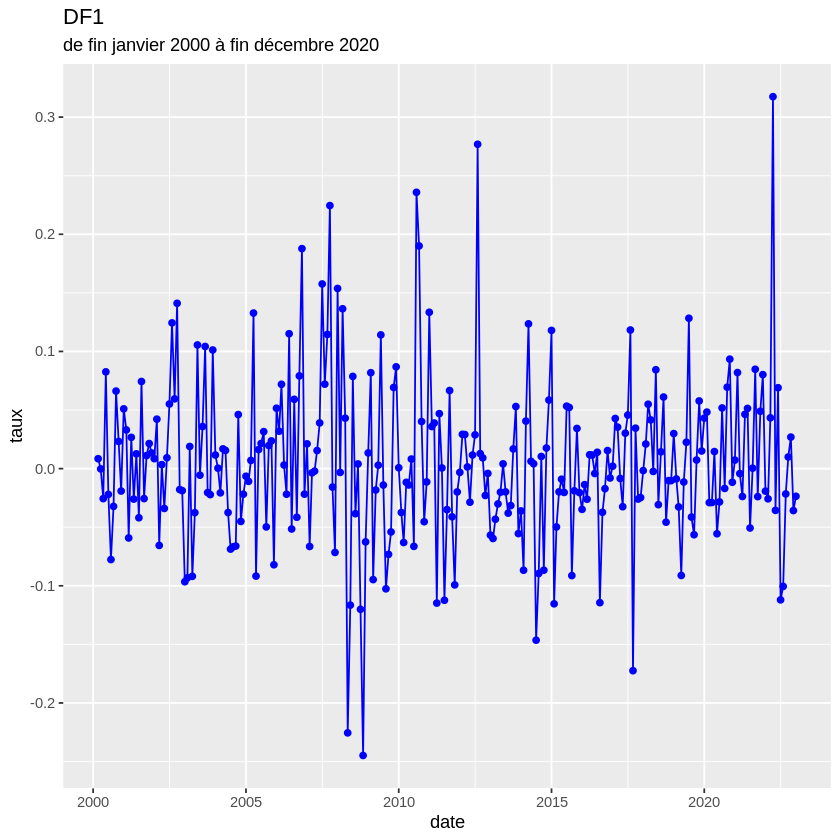

In [ ]:
wheat_data_d1 <- data.frame(wheat_data_df$Date[-1], diff(log(wheat_data_df$Price))) #demander au prof en quel base doit être le log, j'ai l'impression que c'est la différence première
colnames(wheat_data_d1)<-c("Date","rdt")

#Représentation graphique du taux de rendement à l'échelle logarithmique
graph_wheat_rdt<-ggplot(data=wheat_data_d1,aes(x=Date,y=rdt))+geom_point(color='blue')+geom_line(color='blue')
graph_wheat_rdt+labs(x="date",y="taux",title = "DF1",subtitle = "de fin janvier 2000 à fin décembre 2022")


Nous allons désormais tester à nouveau la stationarité de cette série avec les tests Dickey-Fuller et Dickey-Fuller Augmentés.

In [ ]:
library(urca)

#Test df1
df_returns<-ur.df(y = wheat_data_d1$rdt,type=c("none"), lag=10, selectlags = c('AIC'))
summary(df_returns)

# On ne REJETTE pas l'hypothèse nulle donc la série EST stationnaire


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.228403 -0.033184 -0.000925  0.037512  0.309999 

Coefficients:
           Estimate Std. Error t value Pr(>|t|)    
z.lag.1    -0.92735    0.08149 -11.380   <2e-16 ***
z.diff.lag  0.06187    0.06162   1.004    0.316    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07039 on 262 degrees of freedom
Multiple R-squared:  0.4392,	Adjusted R-squared:  0.4349 
F-statistic: 102.6 on 2 and 262 DF,  p-value: < 2.2e-16


Value of test-statistic is: -11.3803 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62


In [ ]:
# Test df2
df_returns2<-ur.df(y = wheat_data_d1$rdt,type=c("drift"), lag=10, selectlags = c('AIC'))
summary(df_returns2)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.232959 -0.036911 -0.005403  0.033469  0.305906 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.004153   0.004350   0.955    0.341    
z.lag.1     -0.934365   0.081831 -11.418   <2e-16 ***
z.diff.lag   0.065409   0.061746   1.059    0.290    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0704 on 261 degrees of freedom
Multiple R-squared:  0.4411,	Adjusted R-squared:  0.4368 
F-statistic:   103 on 2 and 261 DF,  p-value: < 2.2e-16


Value of test-statistic is: -11.4182 65.1899 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.44 -2.87 -2.57
phi1  6.47  4.61  3.79


In [ ]:
# Test df3
df_returns3<-ur.df(y = wheat_data_d1$rdt,type=c("trend"), lag=10, selectlags = c('AIC'))
summary(df_returns3)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.23315 -0.03740 -0.00527  0.03327  0.30651 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.852e-03  9.216e-03   0.527    0.599    
z.lag.1     -9.344e-01  8.199e-02 -11.397   <2e-16 ***
tt          -4.906e-06  5.696e-05  -0.086    0.931    
z.diff.lag   6.541e-02  6.186e-02   1.057    0.291    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07053 on 260 degrees of freedom
Multiple R-squared:  0.4411,	Adjusted R-squared:  0.4347 
F-statistic: 68.41 on 3 and 260 DF,  p-value: < 2.2e-16


Value of test-statistic is: -11.3968 43.2971 64.9432 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -3.98 -3.

Une fois la série différenciée, nous obtenons donc les rendements du cours du blé. Dans les trois cas, la p-value est bien inférieure à 0.05 , ce qui signifie que nous devons rejette l'hypothèse nulle de non-stationnarité. En d'autres termes, la série est bien **stationnaire**. Puisque nous avons dû différencier le processus une fois afin de le stationnariser, cela signifie qu'il est $I(1)$.

###Tests sur le nombre de HDD

####Tests DF pour les HDD

In [ ]:
# TESTS DF sur les HDD

adf1<-ur.df(y = HDD_data_c,type=c("none"), lag=15, selectlags = c('AIC'))
adf2<-ur.df(y = HDD_data_c,type=c("trend"), lag=15, selectlags = c('AIC')) #Avec constante + tendance
adf3<-ur.df(y = HDD_data_c,type=c("drift"), lag=15, selectlags = c('AIC')) #avec constante, sans tendance

summary(adf1)
summary(adf2)
summary(adf3)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.2502 -1.2766  0.0198  1.5034  9.5072 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
z.lag.1      -0.003598   0.013075  -0.275  0.78342    
z.diff.lag1  -0.797739   0.063469 -12.569  < 2e-16 ***
z.diff.lag2  -0.656620   0.080351  -8.172 1.65e-14 ***
z.diff.lag3  -0.486109   0.089769  -5.415 1.47e-07 ***
z.diff.lag4  -0.440013   0.094540  -4.654 5.34e-06 ***
z.diff.lag5  -0.445950   0.097905  -4.555 8.28e-06 ***
z.diff.lag6  -0.425058   0.098684  -4.307 2.40e-05 ***
z.diff.lag7  -0.314511   0.100867  -3.118  0.00204 ** 
z.diff.lag8  -0.273889   0.101010  -2.712  0.00717 ** 
z.diff.lag9  -0.211921   0.100177  -2.115  0.03540 *  
z.diff.lag10 -0.235157   0.097265  -2.418  0.01635 *  
z.di


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.3917  -1.1122  -0.0213   1.1777  10.0881 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  8.8133835  1.2980117   6.790 7.84e-11 ***
z.lag.1     -0.6638327  0.0930014  -7.138 9.84e-12 ***
tt           0.0002378  0.0022964   0.104   0.9176    
z.diff.lag1 -0.1919944  0.0813023  -2.361   0.0190 *  
z.diff.lag2 -0.1085158  0.0619628  -1.751   0.0811 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.778 on 255 degrees of freedom
Multiple R-squared:  0.4278,	Adjusted R-squared:  0.4188 
F-statistic: 47.65 on 4 and 255 DF,  p-value: < 2.2e-16


Value of test-statistic is: -7.1379 17.0076 25.5021 

Critical values for tes


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.4096  -1.1044  -0.0311   1.1599  10.1131 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  8.85033    1.24561   7.105 1.19e-11 ***
z.lag.1     -0.66401    0.09281  -7.155 8.81e-12 ***
z.diff.lag1 -0.19177    0.08112  -2.364   0.0188 *  
z.diff.lag2 -0.10839    0.06183  -1.753   0.0808 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.773 on 256 degrees of freedom
Multiple R-squared:  0.4277,	Adjusted R-squared:  0.421 
F-statistic: 63.78 on 3 and 256 DF,  p-value: < 2.2e-16


Value of test-statistic is: -7.1548 25.605 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.44 -2.87 -2.57
phi1  6.47  4.61  3

**Résultats des tests:** \

La série des HDD est stationnaire : les p-values sont toutes inférieures au seuil de risque de 5%.

####Tests KPSS

In [ ]:
kpss_tau2<-ur.kpss(y=HDD_data_c,type="tau",lags="long")
summary(kpss_tau2)
kpss_mu2<-ur.kpss(y=HDD_data_c,type="mu",lags="long")
summary(kpss_mu2)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: tau with 15 lags. 

Value of test-statistic is: 0.0446 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.119 0.146  0.176 0.216



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 15 lags. 

Value of test-statistic is: 0.0471 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


Les deux tests KPSS ont la même conclusion : les statistiques de test sont inférieures aux valeurs critiques à 10%,5%,2.5% et 1%. Donc nous ne pouvons rejeter l'hypothèse nulle de stationarité autour d'une tendance et d'une moyenne constante.
Cela valide le résultat du test de Dickey-Fuller: le processus est stationnaire.

##4. Estimation d'un modèle ARMA

Après avoir effectué plusieurs tests sur les séries du cours du blé et des HDD, nous souhaitons désormais nous concentrer sur une série, et tenter d'estimer un modèle ARMA(p,q). Nous avons choisi de nous concentrer sur la série du cours du blé, car celle-ci est une série économique. De ce fait, nous avons trouvé plus pertinent, dans le cadre de nos études, de nous attarder sur cette dernière.

Afin d'utiliser un modèle ARMA pour modéliser la série économique, il faut que la série respecte deux conditions: elle doit être **stationnaire** et doit **montrer de l'autocorrélation (partielle ou non)**. Si elle ne présente pas ces deux éléments, nous ne pouvons utiliser une réprésentation sous la forme d'un modèle ARMA.


La procédure d'estimation va nous donner, à partir d'un échantillon de T observations {${X_1, X_2, ..., X_T}$} un modèle de la forme:

$$X_t = c + \sum^p_{i=1} \phi_i X_{t-i} + \epsilon_t + \sum^q_{i=1} ψ_i \epsilon_{t-i} $$


Pour estimer les nombreux paramètres inconnus, il faut alors utiliser l'estimateur du maximum de vraisemblance (EMV).
Précédemment, nous avons identifié la série du cours du blé comme étant un potentiel AR(2). Dans le cas d'un AR(p), l'EMV est égal à l'estimation par les Moindres Carrés Ordinaires (MCO).


In [ ]:
#Installation des packages pour l'estimation du modèle

install.packages("reshape2")
install.packages("moments")
install.packages("tseries")
install.packages("Metrics")
install.packages("tsm")


Il nous faut désormais estimer un modèle ARMA(p,q). Afin de choisir les paramètres p et q, nous allons étudier les autocorrélogrammes partiels et simples de la série différenciée. Cela nous permettra de définir le nombre maximums de retards, soient *$p_{max}$* et *$q_{max}$*.

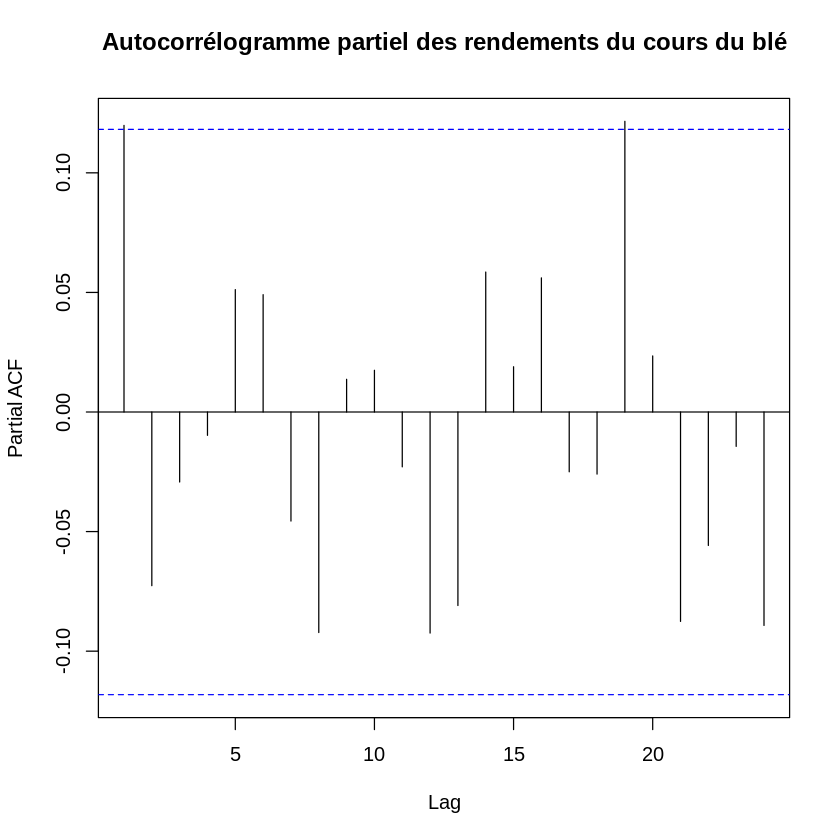

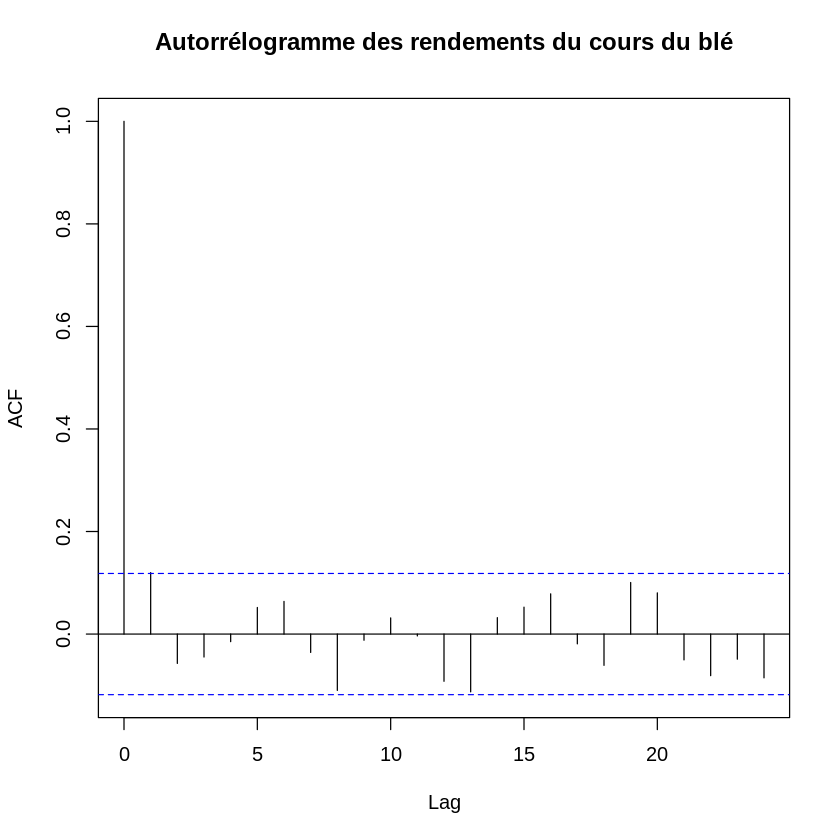

In [ ]:
wheat_pacf <-pacf(wheat_data_d1$rdt,main="Autocorrélogramme partiel des rendements du cours du blé")
wheat_acf<- acf(wheat_data_d1$rdt,main="Autorrélogramme des rendements du cours du blé")

L'autocorrélogramme partiel conserve une forme sinusoïdale, mais la significativité des retards est considérablement réduite. L'autocorrélogramme simple présente une chute considérable à partir du second retard.
Les autocorrélations très faibles ne sont pas atypiques sur des rendements, cela est souvent le cas en présence de bruits blancs dans la série. Cela renvoie à la notion d'efficience des marchés (hypothèse des marchés efficients), selon laquelle il est impossible de "battre le marché" mathématiquement parlant, car les cours suivent une marche aléatoire, rendant leur évolution imprévisible à court-terme. Donc il est techniquement impossible de prédire un cours futur en fonction d'un cours passé.

Puisque nous avons stationarisé la série, nous allons désormais pouvoir essayer de la modéliser. Les autocorrélogrammes simples et partiels semblent nous indiquer que le modèle serait un ARMA(2,1), mais seuls des tests avec différents paramètres p et q nous permettrons d'identifier le modèle "idéal".

In [ ]:
#Recherche des meilleurs p et q pour notre ARMA
library(forecast)

est_df<- data.frame(i = integer(), j = integer(), aic = numeric())

for (i in 1:3){
  for (j in 1:3){
    model=Arima(y=wheat_data_d1$rdt, order=c(i,0,j))
    est_df <- rbind(est_df, data.frame(i = i, j = j, aic = model$aic))
  }
}

print(est_df)

  i j       aic
1 1 1 -680.2613
2 1 2 -678.7688
3 1 3 -676.8694
4 2 1 -678.9354
5 2 2 -684.7060
6 2 3 -683.1053
7 3 1 -677.4421
8 3 2 -683.0531
9 3 3 -681.0304


Ci-dessus, on a créé un tableau dans lequel on fait varier les valeurs de p (i dans le code) et q (j dans le code). Nous nous limitons à un ARMA(3,3).
Nous utilisons le critère AIC, et choisissons le modèle ou celui-ci est le plus petit. Dans notre cas, l'AIC minimisé est lorsque p=2 et q=2.
Nous avons choisi de nous concentrer sur le critère d'information AIC car celui-ci a tendance a surestimer les modèles. Il nous semble plus judicieux de partir d'un modèle légèrement surestimé afin de ne pas oublier de paramètres, même si cela ne respecte pas vraiment le principe de parcimonie appliqué en économétrie.

In [ ]:
#Modèle ARMA(2,2) qui semble le plus approprié
ARMA2 <- Arima(y = wheat_data_d1$rdt,order=c(2,0,2))
summary(ARMA2)

Series: wheat_data_d1$rdt 
ARIMA(2,0,2) with non-zero mean 

Coefficients:
         ar1      ar2      ma1     ma2    mean
      0.4827  -0.9276  -0.4002  0.9122  0.0045
s.e.  0.0702   0.0397   0.0674  0.0568  0.0043

sigma^2 = 0.004726:  log likelihood = 348.35
AIC=-684.71   AICc=-684.39   BIC=-663.01

Training set error measures:
                        ME       RMSE        MAE      MPE     MAPE      MASE
Training set -9.163731e-06 0.06811612 0.04968685 77.91863 167.0911 0.7133821
                   ACF1
Training set 0.03169524

Warning message in abbreviate(snames):
“abbreviate used with non-ASCII chars”


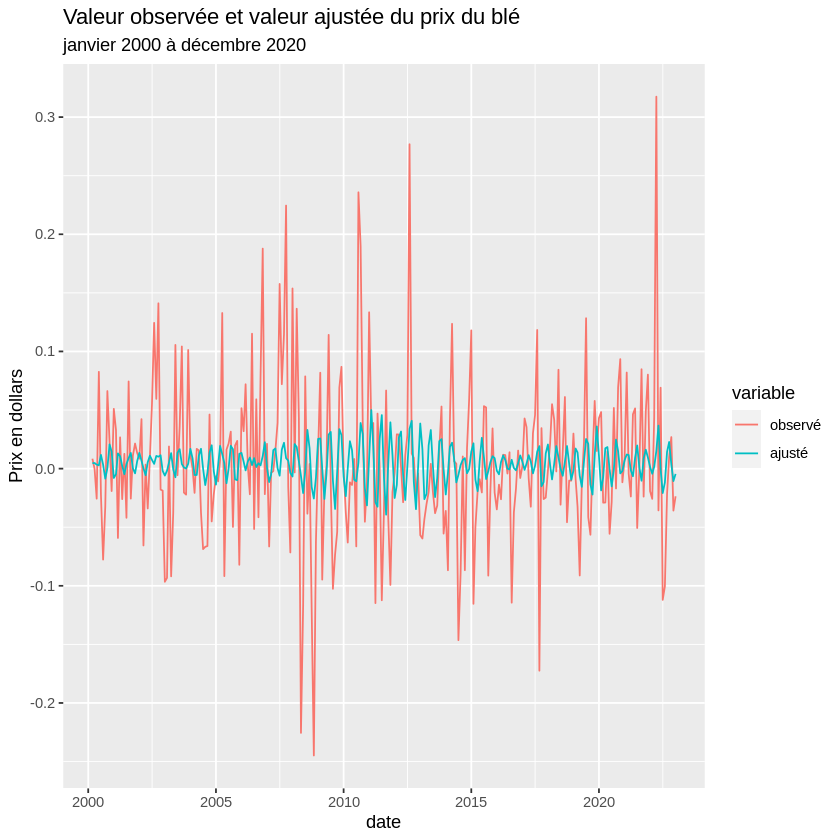

Warning message in abbreviate(snames):
“abbreviate used with non-ASCII chars”


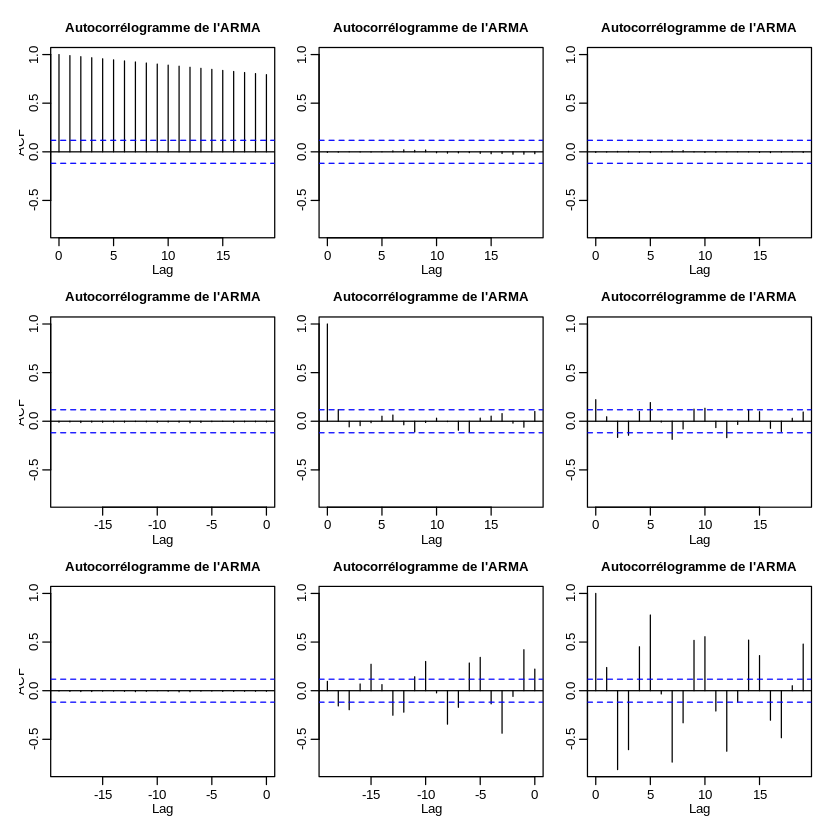

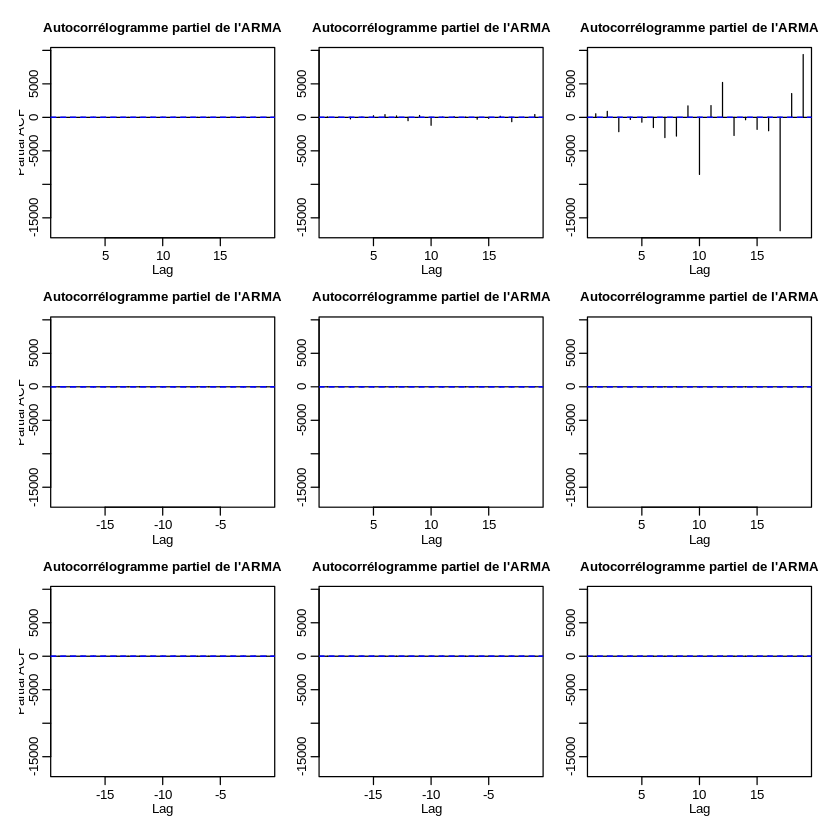

In [ ]:
#Représentation graphique
library(ggplot2)
library(reshape)

df_plot<-data.frame(wheat_data_d1$Date,wheat_data_d1$rdt,F=as.matrix(ARMA2$fitted))
colnames(df_plot)<-c("date","observé","ajusté")

data_melt=melt(as.data.frame(df_plot),id.vars = 1)

p_F_us<-ggplot(data=data_melt,aes(x=date))+geom_line(aes(x=date,y=value,color= variable))
p_F_us+labs(y="Prix en dollars",title = "Valeur observée et valeur ajustée du prix du blé",
            subtitle = "janvier 2000 à décembre 2020")

### ACF et PACF de l'ARMA
arma_acf <- acf(df_plot,main="Autocorrélogramme de l'ARMA")
arma_pacf<-pacf(df_plot,main="Autocorrélogramme partiel de l'ARMA")

Une fois l'estimation réalisée, il faut tester la robustesse du modèle.
Il y en a plusieurs à réaliser, notamment sur la signficativité des coefficients, ainsi que sur les résidus.

####Test de significativité des coefficients

In [ ]:
# TEST 1 : test de significativité des coefficients.

library(lmtest)
test1<- coeftest(ARMA2)
test1



z test of coefficients:

            Estimate Std. Error  z value  Pr(>|z|)    
ar1        0.4826783  0.0701997   6.8758 6.165e-12 ***
ar2       -0.9275548  0.0397329 -23.3447 < 2.2e-16 ***
ma1       -0.4001992  0.0674310  -5.9349 2.939e-09 ***
ma2        0.9122419  0.0567593  16.0721 < 2.2e-16 ***
intercept  0.0045330  0.0042992   1.0544    0.2917    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Nous remarquons que tous les coefficients semblent significatifs à première vue (ils ont tous ***).
Cependant nous allons détailler ci-dessous le test de significativité des coefficients.
Les hypothèses sont les suivantes pour la partie AR(i):

$$\left\{ \begin{array}{c}
H_0: \phi_i = 0 \\
H_1: \phi_i \neq 0 \end {array}
\right.  $$  

Pour la partie MA(j), ce sont les mêmes hypothèses mais avec $\theta_j$.

La statistique de test pour chaque coefficient est : $\vert {t_i} \vert = \frac{\phi_i}{\sigma_\phi}$

Les seuils critiques utilisés sont:

seuil=2.57 pour un risque de première espèce de 1%

seuil= 1.96 pour un risque de première espèce de 5%

*   $ t_{\phi_1} = \frac{0.4826}{0.0701}$ = 6.88> 2.57, donc on rejette l'hypothèse nulle de non-significativité du coefficient pour les seuils à 1% (et donc également 5%).
*   $ t_{\phi_2} = \frac{-0.927}{0.039} $ = 23.76 > 2.57, le coefficient est significativement différent de 0.
* $\vert {\theta_1} \vert$ > 2.57 et $\vert {\theta_2} \vert$ > 2.57 donc les retards 1 et 2 du MA sont aussi significatifs.


Enfin, regardons le coefficient de la constante (*intercept*): il est < 1.96, donc nous concluons qu'elle n'est pas significative dans notre modèle.





####Test d'ajouts de retards


Nous allons désormais tester si faire varier le nombre de retards de ±1 au modèle estimé est nécessaire. Nous commençons par ajouter un retard à chaque.

In [ ]:
arma32<-Arima(wheat_data_d1$rdt,order=c(3,0,2))
summary(arma32)
coeftest(arma32)

Series: wheat_data_d1$rdt 
ARIMA(3,0,2) with non-zero mean 

Coefficients:
         ar1      ar2     ar3      ma1     ma2    mean
      0.5167  -0.9520  0.0375  -0.4030  0.9207  0.0045
s.e.  0.1040   0.0556  0.0637   0.0832  0.0626  0.0045

sigma^2 = 0.004738:  log likelihood = 348.53
AIC=-683.05   AICc=-682.63   BIC=-657.74

Training set error measures:
                        ME       RMSE        MAE      MPE     MAPE      MASE
Training set -1.088726e-05 0.06807489 0.04975877 80.25279 168.1403 0.7144148
                    ACF1
Training set 0.002488887


z test of coefficients:

            Estimate Std. Error  z value  Pr(>|z|)    
ar1        0.5166519  0.1039565   4.9699 6.699e-07 ***
ar2       -0.9520448  0.0555624 -17.1347 < 2.2e-16 ***
ar3        0.0374810  0.0637143   0.5883    0.5564    
ma1       -0.4030178  0.0832083  -4.8435 1.276e-06 ***
ma2        0.9206892  0.0625802  14.7122 < 2.2e-16 ***
intercept  0.0045277  0.0044569   1.0159    0.3097    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


 $\vert \phi_3 \vert = \frac{0.0374}{0.0637}$= 0.58,

 ce qui est en dessous du seuil de 5% (1.96) et de 1% (2.57), donc le coefficient du retard supplémentaire n'est pas significativement différent de 0. De plus, les critères d'informations ne sont pas meilleurs qu'avec notre modèle de base.

 Nous allons ajouter un retard au MA.

In [ ]:
arma23<-Arima(wheat_data_d1$rdt,order=c(2,0,3))
summary(arma23)
coeftest(arma23)

Series: wheat_data_d1$rdt 
ARIMA(2,0,3) with non-zero mean 

Coefficients:
         ar1      ar2      ma1     ma2     ma3    mean
      0.4734  -0.9333  -0.3548  0.9044  0.0429  0.0045
s.e.  0.0907   0.0383   0.1140  0.0647  0.0688  0.0045

sigma^2 = 0.004737:  log likelihood = 348.55
AIC=-683.11   AICc=-682.69   BIC=-657.79

Training set error measures:
                        ME       RMSE        MAE      MPE    MAPE      MASE
Training set -1.322124e-05 0.06806812 0.04977428 81.03567 168.548 0.7146375
                    ACF1
Training set -0.00205057


z test of coefficients:

            Estimate Std. Error  z value  Pr(>|z|)    
ar1        0.4734201  0.0907041   5.2194 1.795e-07 ***
ar2       -0.9333343  0.0383304 -24.3497 < 2.2e-16 ***
ma1       -0.3548294  0.1139717  -3.1133   0.00185 ** 
ma2        0.9044294  0.0647032  13.9781 < 2.2e-16 ***
ma3        0.0429117  0.0687592   0.6241   0.53257    
intercept  0.0045285  0.0044776   1.0114   0.31184    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


$\vert \theta_3 \vert = \frac{0.0429}{0.0687}$= 0.62

ce qui est en dessous du seuil de 5% (1.96) et de 1% (2.57), donc le coefficient du retard supplémentaire n'est pas significativement différent de 0. De plus, les critères d'informations ne sont pas meilleurs qu'avec notre modèle de base.

On observe également que la significativité du premier retard du MA est moins bonne que précédemment.

Finalement, nous allons ajouter un retard à p et q simultanément:

In [ ]:
arma33<-Arima(wheat_data_d1$rdt,order=c(3,0,3))
summary(arma33)
coeftest(arma33)

Series: wheat_data_d1$rdt 
ARIMA(3,0,3) with non-zero mean 

Coefficients:
          ar1      ar2      ar3     ma1     ma2     ma3    mean
      -0.5153  -0.4437  -0.9275  0.5969  0.5106  0.9097  0.0045
s.e.   0.0699   0.0766   0.0398  0.0680  0.1053  0.0569  0.0043

sigma^2 = 0.004749:  log likelihood = 348.52
AIC=-681.03   AICc=-680.49   BIC=-652.1

Training set error measures:
                        ME       RMSE        MAE      MPE     MAPE      MASE
Training set -1.213686e-05 0.06803041 0.04972386 71.76695 176.0675 0.7139136
                   ACF1
Training set 0.03523128


z test of coefficients:

            Estimate Std. Error  z value  Pr(>|z|)    
ar1       -0.5152611  0.0699141  -7.3699 1.707e-13 ***
ar2       -0.4437012  0.0766477  -5.7888 7.087e-09 ***
ar3       -0.9275374  0.0398220 -23.2921 < 2.2e-16 ***
ma1        0.5968506  0.0680119   8.7757 < 2.2e-16 ***
ma2        0.5105927  0.1053021   4.8488 1.242e-06 ***
ma3        0.9097166  0.0569355  15.9780 < 2.2e-16 ***
intercept  0.0045423  0.0042889   1.0591    0.2896    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Un ARMA(3,3) semble avoir des coefficients tous significatifs. Les critères AIC et BIC ne sont pas cependant aussi minimisés qu'avec un ARMA(2,2).
Le principe de parcimonie préconise d'estimer le moins de paramètres possibles. Nous allons donc choisir de conserver notre modèle initial, qui minime davantage les critères AIC et BIC.

Le modèle s'écrit donc:

$$X_t = 0.48267 X_{t-1} - 0.92755 X_{t-2} + \varepsilon_t - 0.40019 \varepsilon_{t-1} + 0.91224 \varepsilon_{t-2}$$

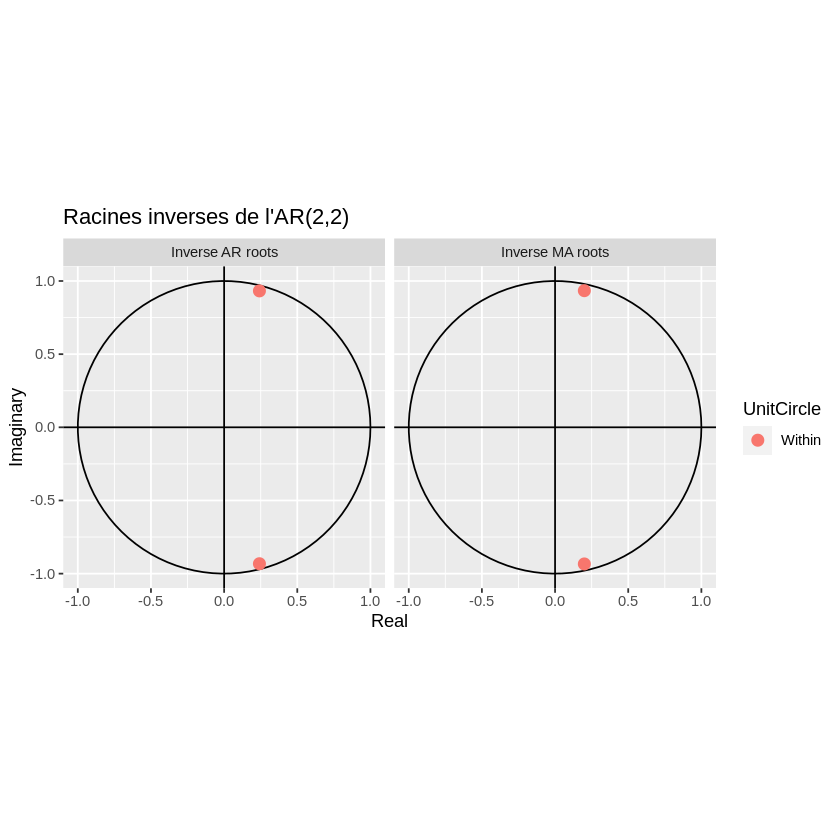

In [ ]:
## Analyse des racines
autoplot(ARMA2, main="Racines inverses de l\'AR(2,2)")


#### Test sur les résidus

Il y a trois tests à réaliser afin de vérifier les résidus de notre modèle ARMA.

#####1.Test d'absence d'autocorrélation des résidus de Llung-Box




	Ljung-Box test

data:  Residuals from ARIMA(2,0,2) with non-zero mean
Q* = 4.807, df = 11, p-value = 0.9402

Model df: 4.   Total lags used: 15



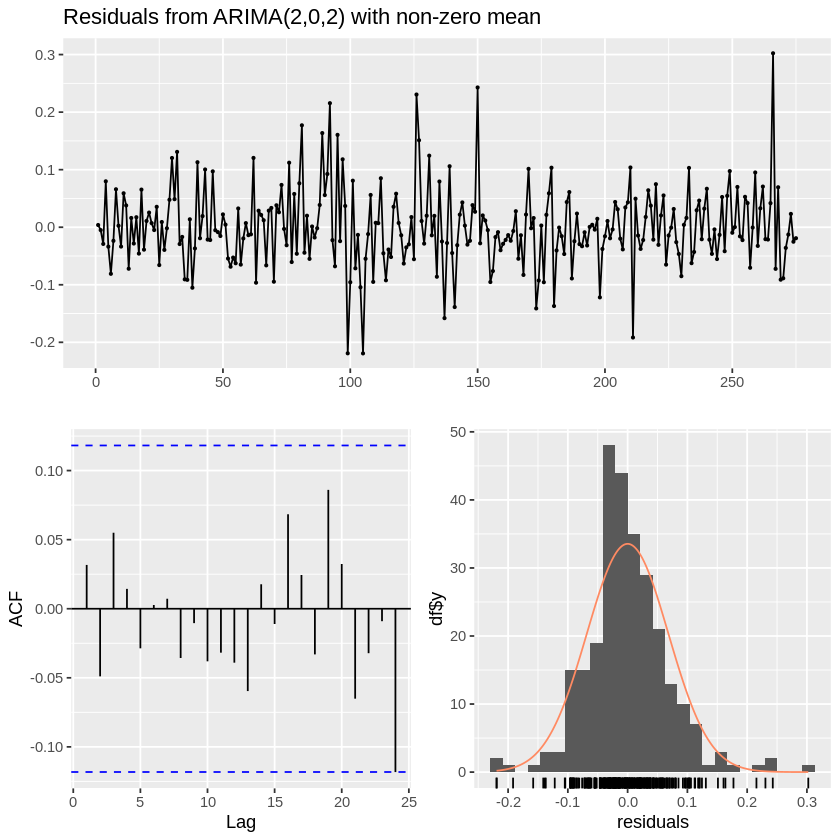

In [ ]:
#Test absence d'autocorrélation des résidus de Llung-Box
residu1<-checkresiduals(ARMA2,lag=15)


La p-value du test est 0.9402 > 0.05, donc on ne rejette pas $H_0$, soit l'hypothèse nulle d'absence d'autocorrélation des résidus. Cela nous indique que notre modèle ARMA(2,2) semble bien répondre à la caractéristique d'absence d'autocorrélation entre les résidus.

Nous pouvons donc passer au prochain test: le test de normalité des résidus.

#####2. Test de l'hypothèse de normalité des résidus de Jarque et Bera

L'objectif est d'étudier la loi de probabilité suivie par les résidus
$\varepsilon_t$ et de vérifier s'ils suivent une loi normale. Pour cela, deux indicateurs sont calculés : le skewness (S), coefficient d'asymétrie d'une distribution, ainsi que le coefficient d'aplatissement d'une distribution, le kurtosis (K).

Le test de Jarque et Bera permet de comparer les skewness et kurtosis de notre modèle avec des valeurs dites de référence de la loi normale.
Les hypothèses du test sont:


$$\left\{ \begin{array}{c}
H_0: S(X) = 0 \ et \ K(X)=3 \\
H_1: S(X)\neq 0 \ ou \ K(X) \neq 3 \end {array}
\right.  $$  

On rejette $H_0$ si la p-value est inférieure au seuil de 5% (0.05).


[1] 266

[1] "Skewness des résidus: 0.550855"

[1] "Kurtosis des résidus: 5.486881"

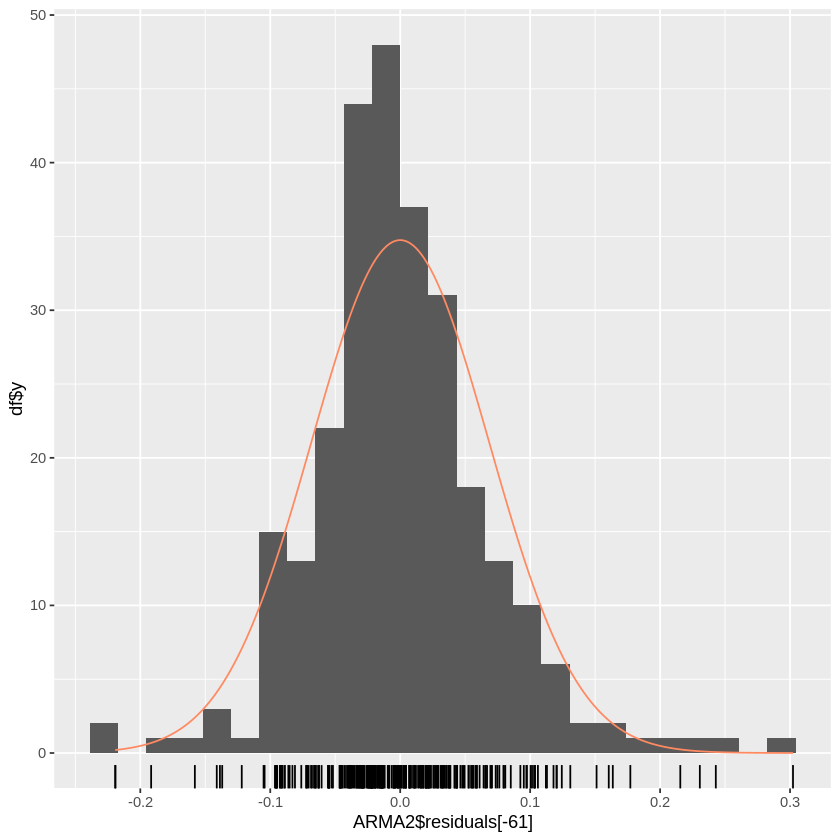

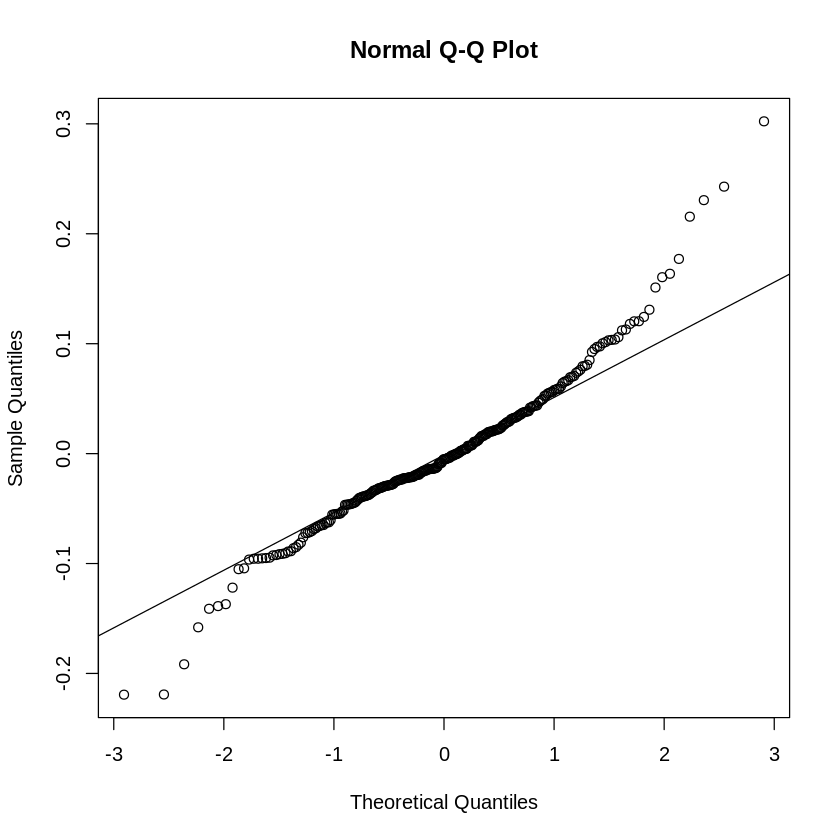

In [ ]:
#test hypothèse normalité des résidus

which(ARMA2$residuals==max(ARMA2$residuals))

#Représentation graphique du skewness et du kurtosis
gghistogram(ARMA2$residuals[-61],add.normal=TRUE)
library(moments)
sprintf("Skewness des résidus: %f",skewness(ARMA2$residuals[-61]))
sprintf("Kurtosis des résidus: %f",kurtosis(ARMA2$residuals[-61]))

qqnorm(ARMA2$residuals[-61])
qqline(ARMA2$residuals[-61])

In [ ]:
#test
library(tseries)

jarque.bera.test(ARMA2$residuals)



	Jarque Bera Test

data:  ARMA2$residuals
X-squared = 86.072, df = 2, p-value < 2.2e-16


La statistique de test est JLB=86.072.
Elle est donc nettement supérieure aux seuils à 5%,2.5% et 1%. Nous rejettons l'hypothèse d'une loi normale pour les résidus.

Une interprétation possible est la présence de deux crises alimentaires en 2008 et 2012, qui ont résulté en deux pics du cours du blé. Cela peut expliquer le kurtosis à 5.4 : la série n'est pas très "applatie", mais au contraire assez "étendue".

#####3. Test d'un effet ARCH

Dans notre cas, ce test est particulièrement intéressant, car c'est il est utilisé pour tester les caractéristiques des séries financières. Il permet de reconnaître si la variance des résidus $\varepsilon_t$ dépend ou non du temps.

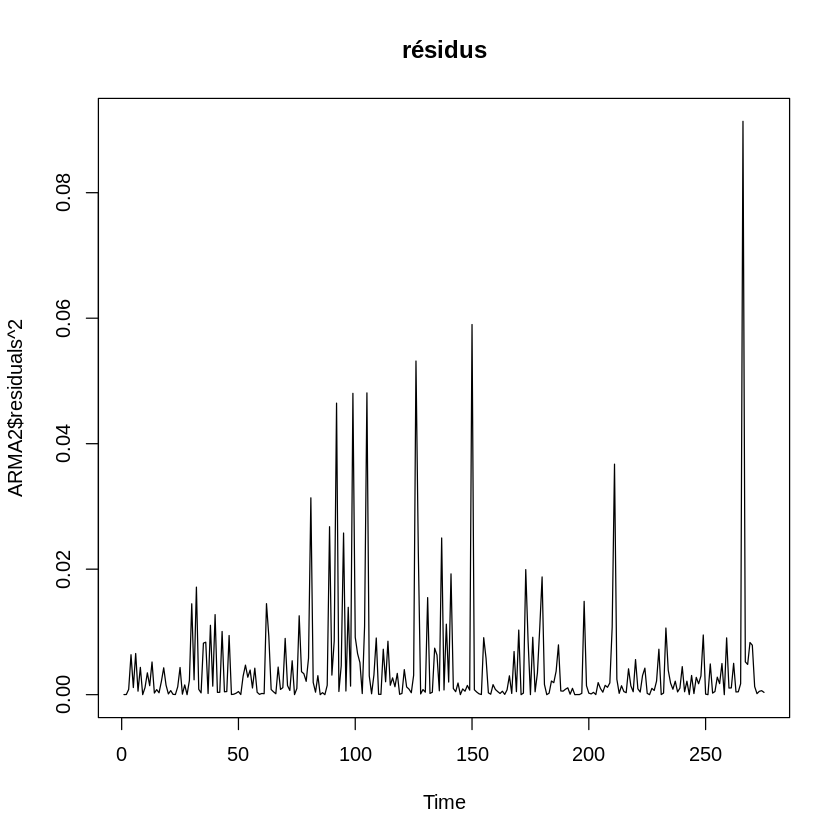

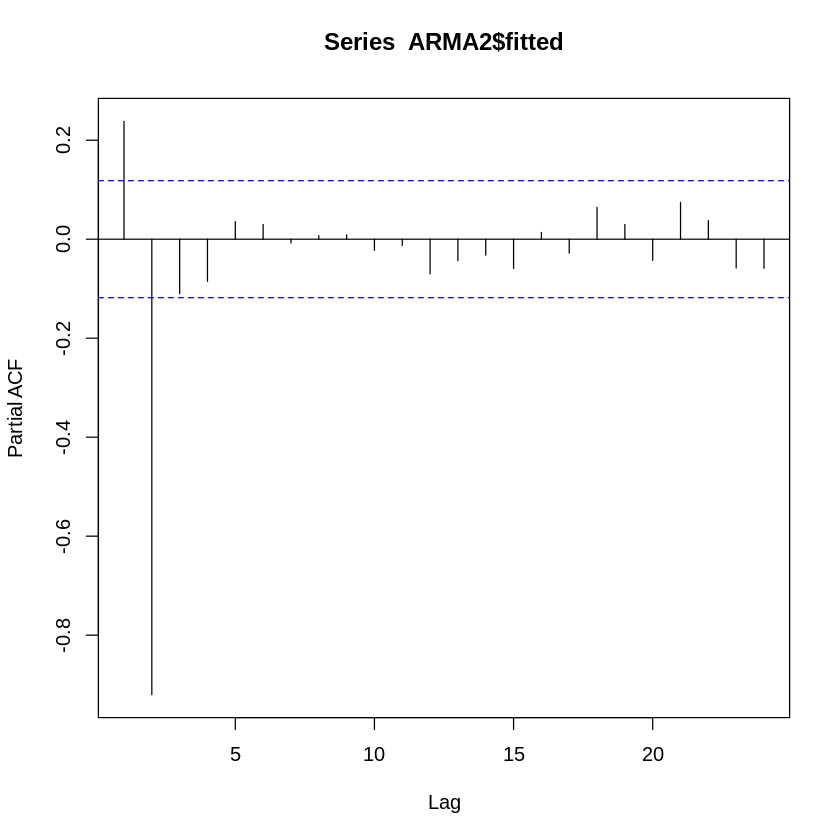

In [ ]:
#choix de p (lags)
plot(ARMA2$residuals^2,main="résidus")
data_pacf<-pacf(ARMA2$fitted)

Nous avons choisi p en fonction de la fonction d'autocorrélation partielle du modèle estimé ARMA(2,2). Sur celle-ci, nous observons que les autocorrélations partielles sont significatives jusqu'à 8. Donc p=8.

In [ ]:
library(FinTS)
ArchTest(ARMA2$residuals,lags=8,demean=FALSE)



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  ARMA2$residuals
Chi-squared = 1.986, df = 8, p-value = 0.9814


La p-value = 0.98 > 0.05, le seuil de 5%.
Donc nous rejetons $H_0$, l'hypothèse nulle qui stipule qu'il n'y a pas d'effet ARCH. Le modèle montre des signes d'hétéroscédasticité conditionelle : la variance des résidus n'est pas constante. Le modèle est soumis à l'effet ARCH. Comme nous l'avons précédemment abordé, il y a eu plusieurs évènements au cours des vingt dernières années qui ont causé d'importantes variations du cours (donc des rendements) du blé dû à des crises alimentaires et économiques. Cela a résulté en des périodes de très hautes volatilité. Ce test a donc bien identifié la présence de clusters de volatilité causés par ces chocs.

##Graphiques combinant les deux séries

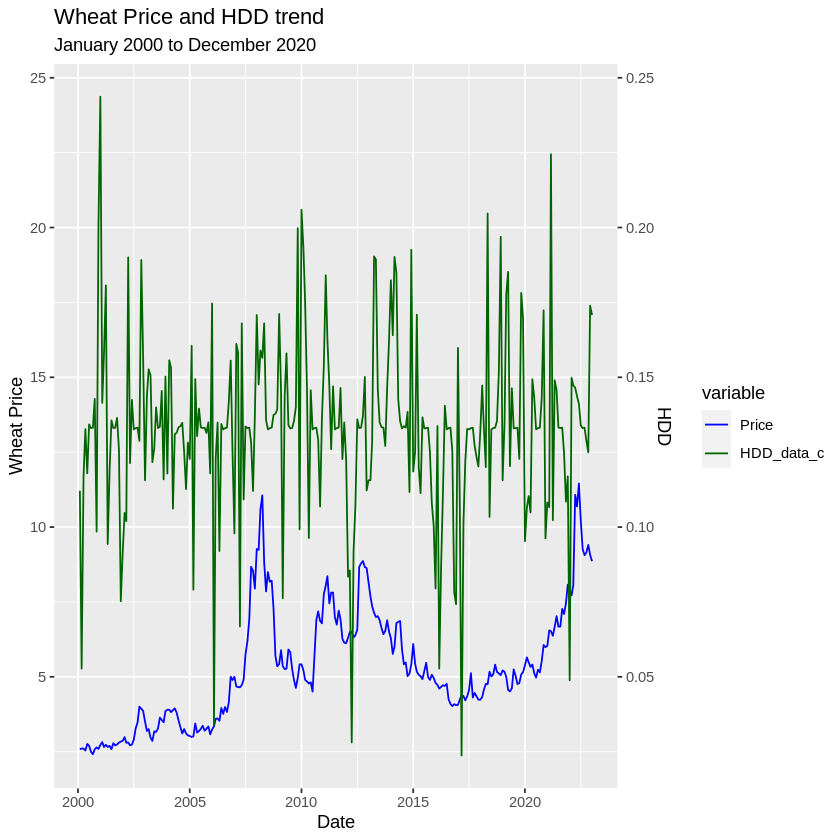

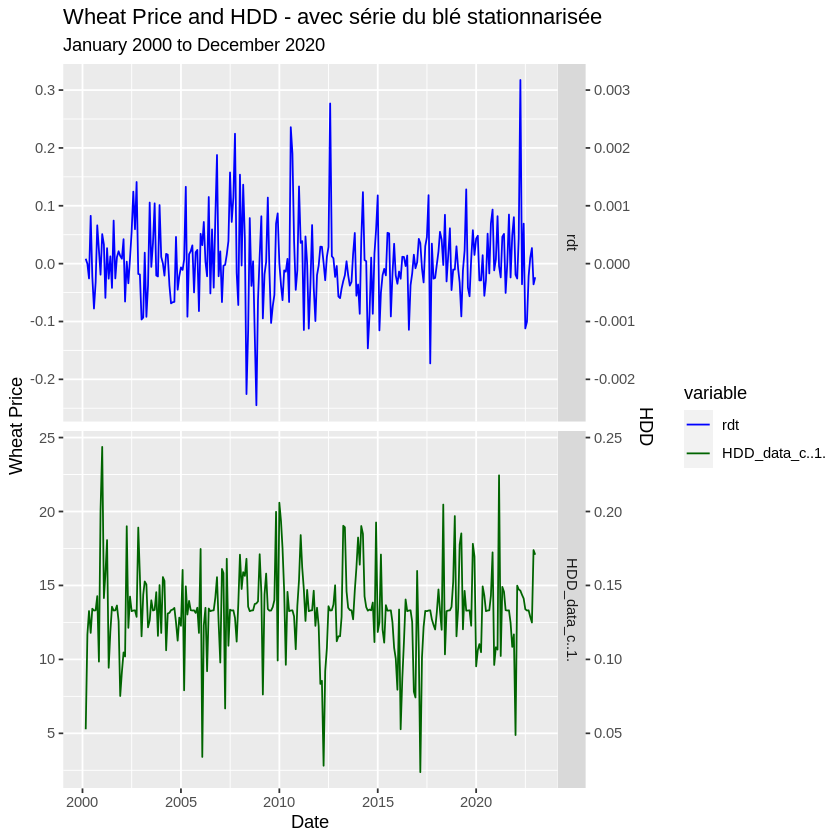

In [ ]:
library(ggplot2)
library(reshape)
data_plot<-data.frame(wheat_data_df,HDD_data_c)
data_melt <- melt(as.data.frame(data_plot), id.vars = 'Date')

graph_tendance_HDD <- ggplot(data = data_melt, aes(x = Date)) +
  geom_line(aes(y = value, color = variable)) +
  scale_y_continuous(name = "Wheat Price",sec.axis = sec_axis(~.*0.01, name = "HDD")) +
  scale_color_manual(values = c('blue', 'dark green')) +
  labs(y = "Wheat Price", title = "Wheat Price and HDD trend", subtitle = "January 2000 to December 2020") +
  ylab("Wheat Price") +
  xlab("Date")

graph_tendance_HDD

data_plot<-data.frame(wheat_data_d1,HDD_data_c[-1])
data_melt <- melt(as.data.frame(data_plot), id.vars = 'Date')

graph_combine <- ggplot(data = data_melt, aes(x = Date)) +
  geom_line(aes(y = value, color = variable)) +
  facet_grid(variable ~ ., scales = "free_y") +
  scale_y_continuous(name = "Wheat Price",sec.axis = sec_axis(~.*0.01, name = "HDD")) +
  scale_color_manual(values = c('blue', 'dark green')) +
  labs(y = "Wheat Price", title = "Wheat Price and HDD - avec série du blé stationnarisée", subtitle = "January 2000 to December 2020") +
  ylab("Wheat Price") +
  xlab("Date")

graph_combine


##5. Calcul des prévisions des séries modélisées sur les horizons de 1 à 3

In [ ]:
library(forecast)

forecast_ARMA <-forecast(ARMA2,h=12,level=95)
forecast_ARMA


    Point Forecast      Lo 95     Hi 95
276   1.303185e-02 -0.1217038 0.1477675
277   1.730612e-02 -0.1178870 0.1524993
278   2.815113e-03 -0.1324183 0.1380485
279  -8.143990e-03 -0.1436579 0.1273699
280   7.488184e-06 -0.1357012 0.1357162
281   1.410720e-02 -0.1216786 0.1498930
282   1.335188e-02 -0.1227285 0.1494323
283  -9.095086e-05 -0.1361714 0.1359895
284  -5.878913e-03 -0.1422101 0.1304523
285   3.796325e-03 -0.1325953 0.1401879
286   1.383501e-02 -0.1226759 0.1503459
287   9.706144e-03 -0.1269604 0.1463727

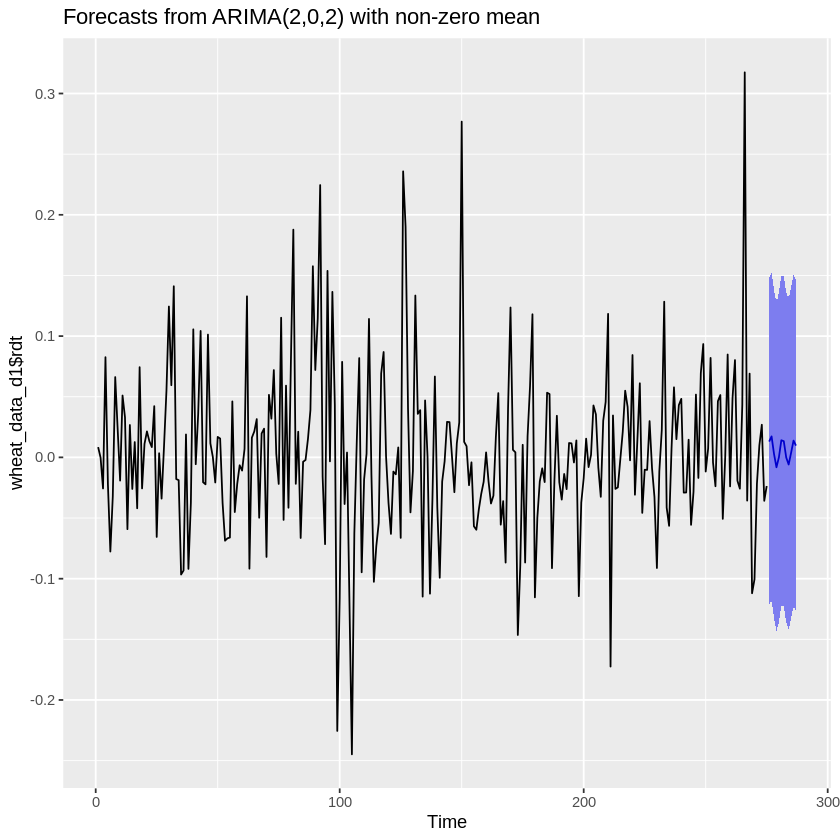

In [ ]:
autoplot(forecast_ARMA)

Détail des calculs des prévisions pour horizon h=1 (mois de février 2023):

Nous avons un ARMA(2,2), son équation s'écrit:

$$X_t = \hat{\phi_1} X_{t-1}+ \hat{\phi_2} X_{t-2} + \varepsilon_t + \hat{\theta_1} \varepsilon_{t-1} + \hat{\theta_2} \varepsilon_{t-2} $$

Avec les valeurs estimées des coefficients:

$$ X_t= 0.48267 X_{t-1} - 0.92755 X_{t-2} + \varepsilon_t - 0.40019 \varepsilon_{t-1} + 0.91224 \varepsilon_{t-2}$$

Nous souhaitons estimer :
$$X_{t+1} = \hat{\phi_1} X_{t} + \hat{\phi_2} X_{t-1} + \varepsilon_{t+1} + \hat{\theta_1} \varepsilon_{t} + \hat{\theta_2} \varepsilon_{t-1} $$

L'erreur de prévision est $\varepsilon_{t+1} $ à l'horizon h=1.
$E(e_t(1))=0$ et le prédicteur $X^{a}_t(1)$ est sans biais.
Les prévisions à tout horizon vont dépendre des deux dernières observations, c'est-à-dire des deux derniers mois.

On peut donc ré-écrire : $X^{a}_t(1)= 0.48267 X_{t} - 0.92755 X_{t-1} -0.40019 \varepsilon_{t} + 0.91224 \varepsilon_{t-1} $




In [ ]:
#rendements en t et t-1
tail(wheat_data_d1,n=2)

#résidus en t et t-1 (estimés dans l'arma)
tail(forecast_ARMA$residuals,n=2)

#rappel des coefficients
ARMA2$coef


,Date,rdt
,<date>,<dbl>
274,2022-12-01,-0.03580331
275,2023-01-01,-0.02361417


A Time Series:
[1] -0.02518943 -0.01911456

ar1          ar2          ma1          ma2    intercept 
 0.482678274 -0.927554825 -0.400199195  0.912241900  0.004532973

L'équation se ré-écrit ainsi:
$ wheat.returns^a_{02.2023} = 0.482678 \times rdt_{275} - 0.927554 \times rdt_{274} - 0.40019 \varepsilon_{t-1} + 0.912241 \times \varepsilon_{t-2} $

En ajoutant les valeurs des rendements du blé et celles des résidus:
$ wheat.returns^a_{02.2023} =  0.482678 \times (-0.023614) - 0.927554 \times (-0.035803) - 0.40019 \times (-0.0191145) + 0.912241 \times (-0.025189) = 0.006477 $

L'erreur $\varepsilon_{t+1} = \hat{X}_{t+1}- X^{a}_t(1)= 0.01303 - 0.006477 = 0.006553$

Pour un horizon h=2, nous ré-utilisons les valeurs estimées de $X_{t+1}$ et $\varepsilon_{t+1}$ .

$ wheat.returns^a_{03.2023} = 0.482678 \times X^{a}_t(1) - 0.927554 \times X_t - 0.40019 \times \varepsilon_{t+1} + 0.912241 \times \varepsilon_{t} $

$ wheat.returns^a_{03.2023} = 0.482678 \times 0.006477 - 0.927554 \times (-0.023614) - 0.40019 \times 0.006553 + 0.912241 \times 0 = 0.022407 $

Pour l'horizon h=3, comme h>q, la partie MA est égale à 0. Donc il ne nous reste plus que la partie AR, que l'on a estimé jusqu'à présent.

$ wheat.returns^a_{04.2023} = 0.482678 \times 0.022407 - 0.927554 \times 0.006477 = 0.004807$

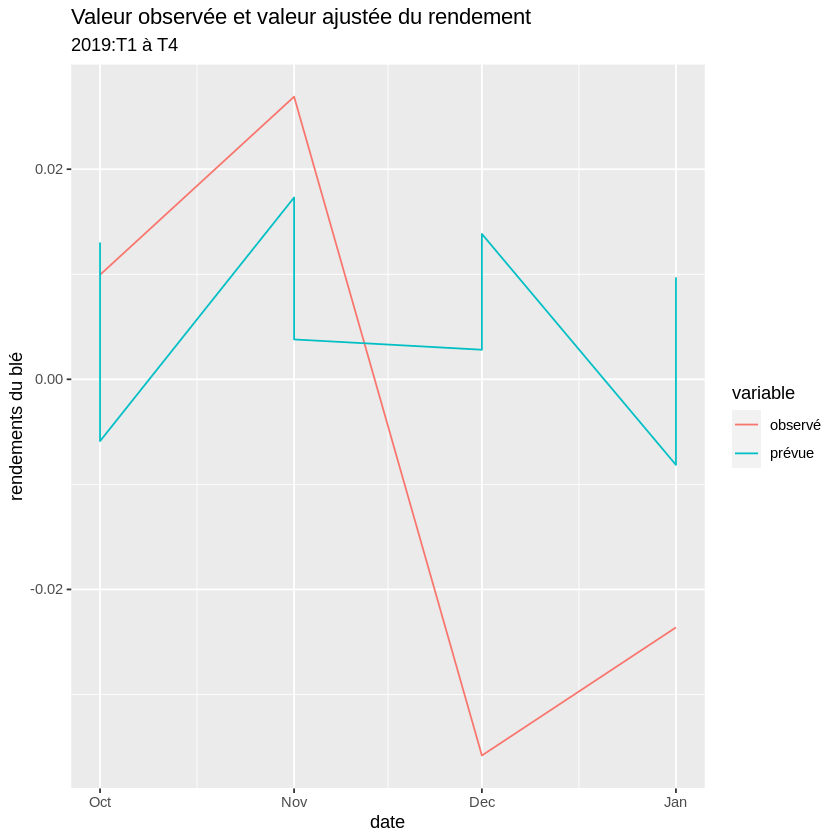

In [ ]:

df_forc<-data.frame(wheat_data_d1$Date[272:275],wheat_data_d1$rdt[272:275],as.matrix(forecast_ARMA$mean))

colnames(df_forc)<-c("date","observé","prévue")


data_F_melt=melt(as.data.frame(df_forc),id.vars = 1)

p_g_us<-ggplot(data=data_F_melt,aes(x=date))+geom_line(aes(x=date,y=value,color= variable))
p_g_us+labs(y="rendements du blé",title = "Valeur observée et valeur ajustée du rendement",
            subtitle = "2019:T1 à T4")


Nous remarquons que la première estimation (pour Octobre) semble légèrement sous-estimée, puis il y a un léger décalage d'un mois sur les variations: la chute observée en novembre n'est prévu qu'en décembre, et la reprise de janvier est en réalité observée dès décembre.

#####Evaluation de la qualité des prévisions

In [ ]:
library(Metrics)
sprintf("MAE out of sample %f", mae(df_forc$`observé`,df_forc$`prévue`))
sprintf("RMSE out of sample %f", rmse(df_forc$`observé`,df_forc$`prévue`))




Attaching package: ‘Metrics’


The following object is masked from ‘package:forecast’:

    accuracy




[1] "MAE out of sample 0.023673"

[1] "RMSE out of sample 0.028023"

La MAE (Mean Absolute Error), soit l'erreur absolue moyenne est très faible, ce qui est préférable car cela signifie que l'écart entre les valeurs observées et les valeurs prédites par le modèle est faible. Donc notre modèle semble plutôt bien adapté.
De même, la RMSE, l'erreur quadratique moyenne (Root Mean Square error), est elle aussi très proche de 0.
En résumé, ces valeurs indiquent que le modèle a une bonne performance en termes d'ajustement aux données hors échantillon, avec des erreurs de prédiction relativement faibles.

##5.b Estimation d'un modèle GARCH

Puisqu'il y a la présence d'un effet ARCH sur les résidus de notre modèle, et que notre série est constituée de données financières, nous avons décidé d'essayer d'estimer un modèle GARCH (Generalized Autoregressive Conditional Heteroskedasticity) qui, nous l'espérons, donnera un modèle encore plus pertinent.

Le modèle GARCH standard est aussi un modèle à volatilité conditionnelle. C'est-à-dire qu'un niveau de variance constant est établi, puis une volatilité dite conditionnelle qui varie.
Il y a donc une condition à respecter pour cela:
$$ \alpha_1 + ... + \alpha_q + β_1 + ... + \beta_p < 1$$  
Soit la somme des paramètres estimés du modèle doivent être inférieurs à 1.


####Modélisation

In [ ]:
install.packages('rugarch')

In [ ]:
#installation du package nécessaire
library(rugarch)
garch_spec <- ugarchspec(variance.model=list(model="sGARCH", garchOrder=c(1,1)), mean.model=list(armaOrder=c(2,2)))
fit_garch <- ugarchfit(spec = garch_spec, data = wheat_data_d1$rdt)
fit_garch

Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma





*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(2,0,2)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.004493    0.004234   1.0611  0.28863
ar1     0.465358    0.085845   5.4209  0.00000
ar2    -0.936155    0.037981 -24.6479  0.00000
ma1    -0.391898    0.070151  -5.5865  0.00000
ma2     0.929799    0.068539  13.5660  0.00000
omega   0.000232    0.000215   1.0780  0.28104
alpha1  0.021428    0.017185   1.2469  0.21244
beta1   0.930821    0.054041  17.2243  0.00000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.004493    0.004046   1.1105 0.266800
ar1     0.465358    0.156456   2.9744 0.002936
ar2    -0.936155    0.038025 -24.6196 0.000000
ma1    -0.391898    0.119947  -3.2673 0.001086
ma2     

La fonction ugarchfit nous fournit divers éléments pour attester de la pertinence de notre modèle.
Mu est la constante moyenne du modèle, nous remarquons qu'elle n'est pas significative.
Ensuite, nous regardons les autres paramètres: omega est la constante, alpha1 est le coefficient pour les termes passés de variance, et beta1 est le coefficient pour les carrés des résidus passés. Un rapide test de significativité des coefficients nous montre que seul beta1 est significatif à 5% (t-stat > 1.96).

Les tests de Ljung-Box sur les résidus indiquent l'absence d'autocorrélation significative. Les tests ARCH LM sur les résidus suggèrent l'absence d'hétéroscédasticité conditionnelle significative. Le Nyblom Stability test semble attester que le modèle est stable. Le test sur les biais montre qu'il existe un fort biais sur les résidus. Enfin, le test de Pearson "Adjusted Goodness-of-fit", qui évalue l'ajustement global du modèle, suggère un ajustement adéquat.

La représentation graphique ci-dessous nous permet également de comparer le modèle GARCH au modèle ARMA précédemment estimé. Chaque modèle présente ses avantages et ses biais. Ici, nous allons préférer conserver le modèle qui minimise le plus les différents critères d'information, donc le modèle ARMA(2,2).




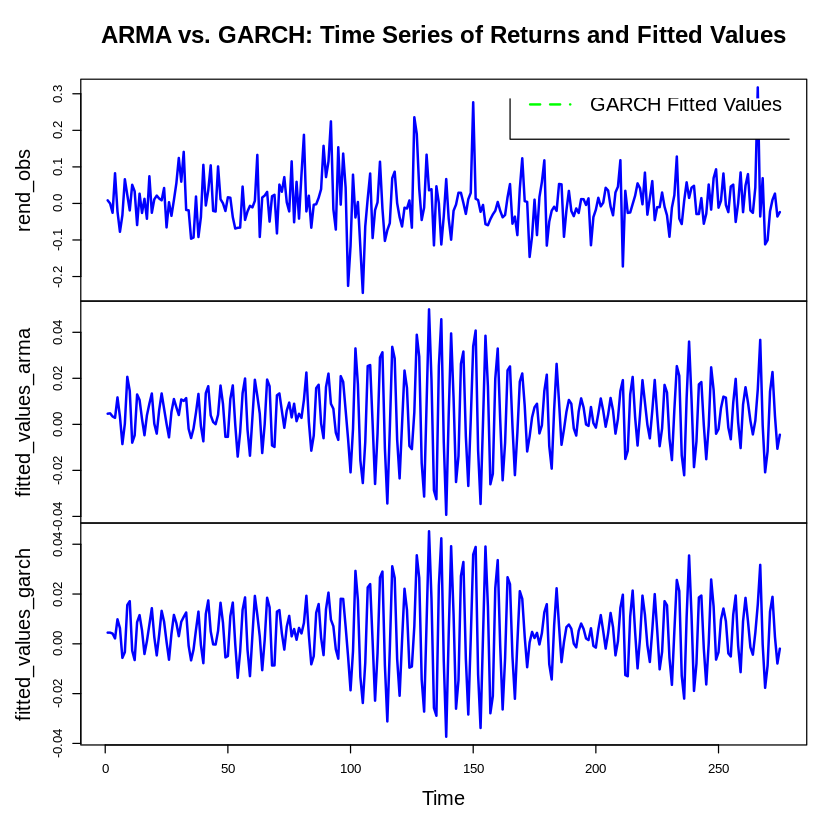

In [ ]:
# Spécifiez les rendements observés, les rendements ARMA ajustés et les rendements GARCH ajustés
rend_obs <- wheat_data_d1$rdt
fitted_values_arma <- fitted(ARMA2)
fitted_values_garch <- fitted(fit_garch)

# Trouvez les limites appropriées pour l'axe y
ylim_min <- min(c(rend_obs, fitted_values_arma, fitted_values_garch))
ylim_max <- max(c(rend_obs, fitted_values_arma, fitted_values_garch))

# Séries temporelles des rendements et des rendements prévus
plot.ts(cbind(rend_obs, fitted_values_arma, fitted_values_garch),
        main="ARMA vs. GARCH: Time Series of Returns and Fitted Values",
        ylab="Returns and Fitted Values", col=c("blue", "red", "green"), lty=c(1, 2, 2), lwd=2,
        ylim=c(ylim_min, ylim_max))
legend("topright", legend=c("Returns", "ARMA Fitted Values", "GARCH Fitted Values"),
       col=c("blue", "red", "green"), lty=c(1, 2, 2), lwd=2)

#Partie 2 : Modélisation multivariée

##6. Estimation du modèle VAR

On utilise le modèle de VAR pour étudier les relations possibles entre le cours du blé et les heating degree days.
En d'autres thermes, existe-t-il un lien assez explicite entre d'importantes variations de températures extrêmes au Kansas et le cours du blé ?\
Pour estimer ce modèle, on travaille avec la différence première de nos séries en logarithme de la série temporelle sur le cours du blé et la série corrigées de la saisonnalité du nombre de HDD, car nous avons montré que celles-ci étaient bien stationnaires (sans dérive).

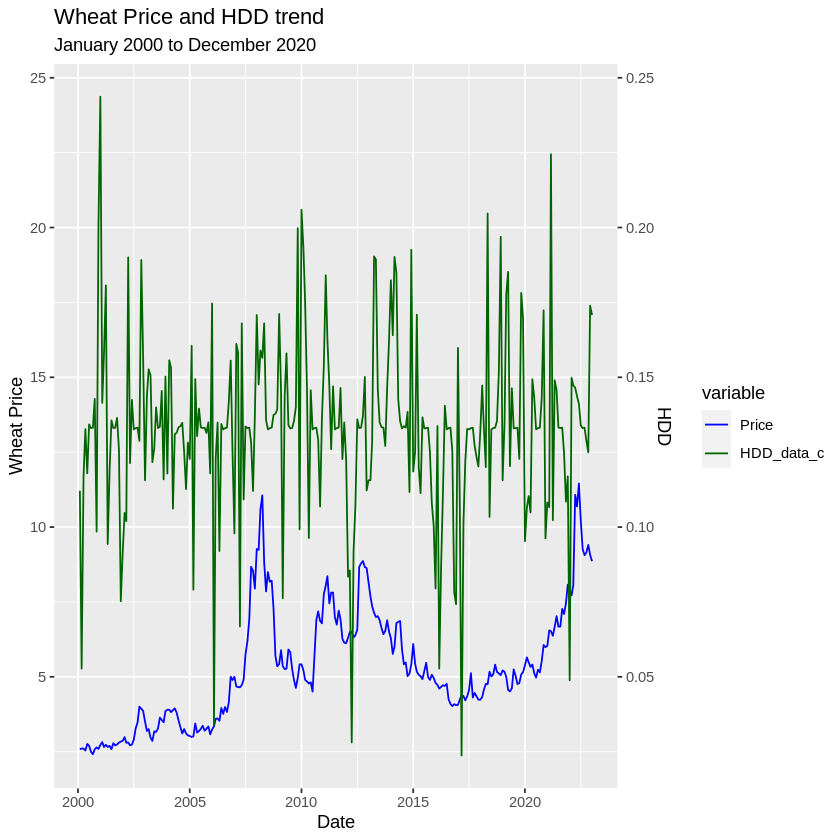

In [ ]:
graph_tendance_HDD

On note deux pics majeurs sur la période pour le prix du blé (indicé "Price"), le premier survient autour et pendant la crise économique de 2008 (qui correspond également à une période de bulle spéculative *c.f. Annexe*) et l'autre en 2022 ce qui correspond au regain de l'inflation aux États-Unis et en Europe.\
Les deux séries semblent avoir des évolutions indépendantes. Cela peut être dû au fait que nous nous soyons concentrées sur les données météorologiques d'une région en particulier, alors que le prix du blé sur le marché des matières premières dépend d'un grand nombre de producteurs.\
Grâce au modèle VAR, nous allons pouvoir étudier ces deux séries simultanément et tirer des conclusion plus précises sur leur causalité que celles que l'on peut faire en regardant simplement un graphique les combinant et que l'on a pu faire dans la partie 1.

####Instalation des packages

In [ ]:
#Installation des packages

install.packages("ggplot2")
install.packages("reshape2")
install.packages("vars")
install.packages("lpirfs")

####Test sur la corrélaiton entre les deux séries

####Sélection du nombre de retards optimal

Pour sélectionner le nombre optimal de retards dans un modèle VAR (Vector Autoregression), on utilise les critères d'information multivariés. On procède en spécifiant les paramètres nécessaires :

* lag.max : Nombre maximal de retards.
* type : forme de la composante déterministe, pouvant prendre les valeurs "const", "trend", "both", ou "none"

On ne peut choisir qu'une seule spécification, et celle-ci dépend de l'allure des graphiques de nos données et des données elles-mêmes.\
\
On choisit 8 pour lag.max pour avoir deux années de recul. Et pour le type, on choisit "const" car les données sur les HDD présentent une moyenne constante au cours des années (série staionnaire).

In [ ]:
library(vars)

#On récupère le dataframe comportant les deux série
df_merged <- data_plot
colnames(df_merged) = c("Date","Wheat","HDD")
pselect<-VARselect(y=df_merged[,c("Wheat","HDD")],lag.max=12,type=c("const"))

In [ ]:
pselect$criteria # valeurs des critères de sélection

,1,2,3,4,5,6,7,8,9,10,11,12
AIC(n),-3.21283096,-3.19806643,-3.21030291,-3.19573794,-3.17404969,-3.1527720,-3.14524465,-3.12998635,-3.16351863,-3.14796346,-3.15177499,-3.13293590
HQ(n),-3.18008046,-3.14348227,-3.13388508,-3.09748646,-3.05396454,-3.0108531,-2.98149217,-2.94440020,-2.95609882,-2.91870999,-2.90068785,-2.86001510
SC(n),-3.13133695,-3.06224308,-3.02015022,-2.95125592,-2.87523833,-2.7996313,-2.73777461,-2.66818697,-2.64738991,-2.57750540,-2.52698759,-2.45381916
FPE(n),0.04024261,0.04084147,0.04034541,0.04093849,0.04183793,0.0427404,0.04306706,0.04373418,0.04229805,0.04296875,0.04281447,0.04363986


In [ ]:
pselect$selection # nombre de retards optimal selon les critères de sélection

AIC(n)  HQ(n)  SC(n) FPE(n) 
     1      1      1      1

On déduit des valeurs que retourne la fonction *VARselect* que tous les critères préconisent de ne prendre qu'un retard. De plus, 1<8, donc nous respectons la condition.

####Estimation du modèle VAR(1)

L'estimation d'un modèle VAR (Vector Autoregression) a pour objectif de modéliser les relations dynamiques entre plusieurs séries temporelles. En particulier pour analyser des chocs, faire des prévisions ou encore faire des analyses impulsion-réponse.\
Autrement dit, cet outil permet de comprendre les relations temporelles entre plusieurs variables (ici, séries temporelles).



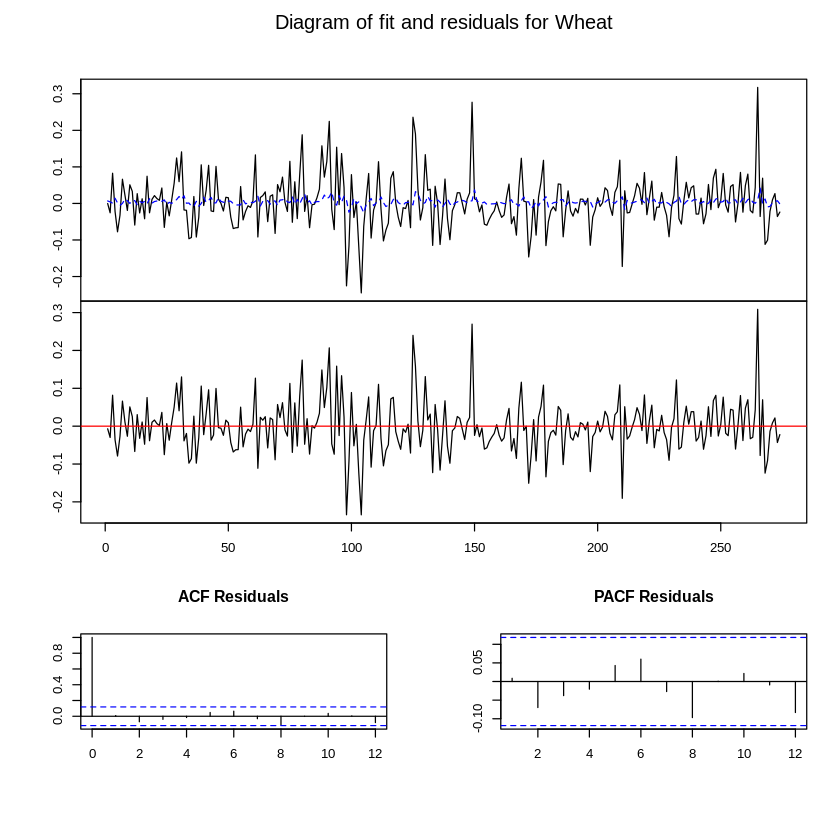


VAR Estimation Results:
Endogenous variables: Wheat, HDD 
Deterministic variables: const 
Sample size: 274 
Log Likelihood: -333.273 
Roots of the characteristic polynomial:
0.1873 0.1116
Call:
VAR(y = df_merged[, c("Wheat", "HDD")], type = "const", lag.max = 1)


Estimation results for equation Wheat: 
Wheat = Wheat.l1 + HDD.l1 + const 

           Estimate Std. Error t value Pr(>|t|)  
Wheat.l1  0.1200873  0.0603339   1.990   0.0476 *
HDD.l1   -0.0002261  0.0014405  -0.157   0.8754  
const     0.0069299  0.0196613   0.352   0.7248  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard error: 0.06985 on 271 degrees of freedom
Multiple R-Squared: 0.01446,	Adjusted R-squared: 0.007185 
F-statistic: 1.988 on 2 and 271 DF,  p-value: 0.139 


Estimation results for equation HDD: 
HDD = Wheat.l1 + HDD.l1 + const 

         Estimate Std. Error t value Pr(>|t|)    
Wheat.l1  -2.5327     2.4711  -1.025  0.30631    
HDD.l1     0.1788     0.0590   3.030  0.0026

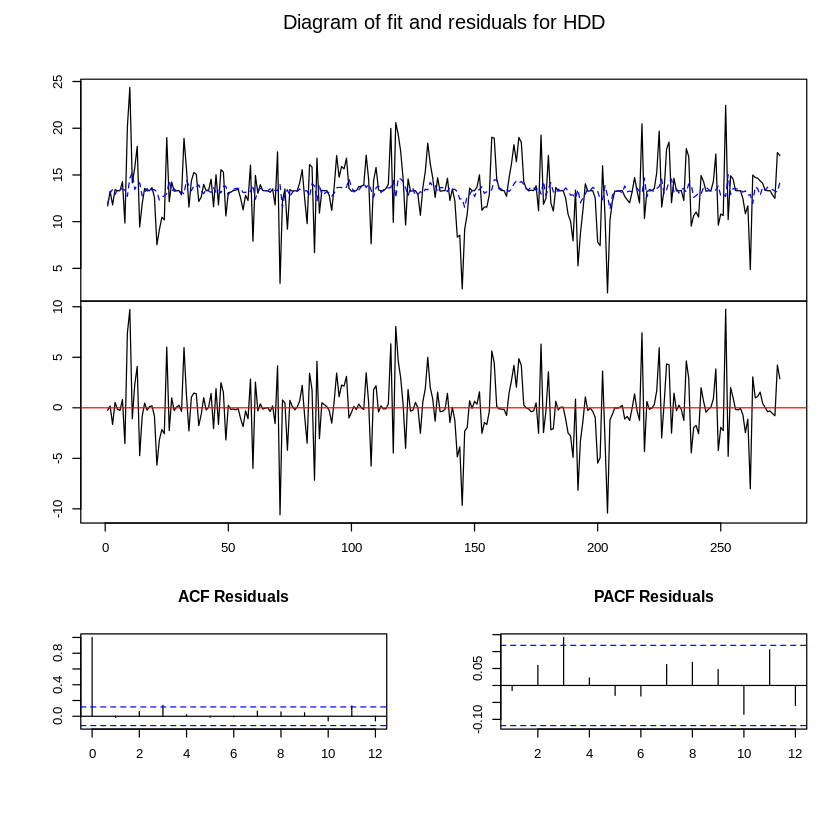

In [ ]:
var.1lag <-VAR(y = df_merged[,c("Wheat","HDD")],type="const",lag.max = 1)
plot(var.1lag)
summary(var.1lag) #Affichage des résultats avec summary


Wheat.l1 et HDD.l1 représentent respectivement Wheat(le cours du blé non stationnarisé) et HDD(les heating degree days) avec un retard d'une période.\
\
**Equation du Blé**

* le coefficient de Wheat.l1 est significatif et positif pour un risque de première espèce de 5% : la croissance du prix du blé est positivement corréle à sa valeur passée
* le coefficient de HDD.l1 est négatif et non significatif, l'évolution positive ou négative du cours du blé est sans effet sur les HDD. Il y a une forme de corrélation négative. Ce résultat est plutôt étonnant, les heating degree days sont des données météorologiques il est donc très surprenant que le modèle affirme qu'elles soient lien avec le prix du blé.
*  la constante est non significative, on en déduit que la partie constante n'est pas portée par ces données.
* le $R^{2}$ est égal à 1.5%, le pouvoir explicatif de la régression est très faible.

**Equation des HDD**

* le coefficient de Wheat.l1 est positif et non significatif ; une augmentation des heating degree days n'a pas d'effet sur le cours du blé a priori. On aurait pu s'attendre à ce qu'il y ait un lien. En effet, si les heating degree days(HDD) augmentent ou baissent alors la production du blé en est nécessairement impacté. Une baisse des HDD (donc hausse de la température) pourrait affecter négativement la production de blé notamment pendant la période de floraison (source : mon papa, je vais chercher une source plus scientifique).
* le coefficient de Wheat.l1 est positif et significatif pour un risque de première espèce 1% : la croissance des HDD est positivement corréle à sa valeur passée
* la constante est significative pour un risque de première espèce de 0.1%, elle est donc très significative
* le $R^{2}$ est égal à 3.5% : le pouvoir explicatif de la régression est plus important que pour Wheat mais reste faible.

On étudie la stationnarité du VAR. La fonction roots renvoie les module des inverses des racines du polynôme caractéristique.

In [ ]:
roots(var.1lag)

[1] 0.1872808 0.1115652

Si les inverses des racines sont de module strictement inférieur à 1 : la condition de stationnarité est donc satisfaite. Ici, c'est bien le cas :\
\
$$\left\{ \begin{array}{c}
\vert 0.19 \vert < 1\\
\vert 0.11 \vert < 1
\end {array}\right. $$  
donc la condition de stationnarité est satisfaite.


##7. Obvservation et commentaires des possibles relation de causalité entre les variables

Nous allons désormais vérifier s'il y a une relation de causalité entre les variables, en d'autres termes, nous soumettons le modèle VAR(1) estimé à des tests.\
Notre intuition première est que le cours du blé soit en partie influencé par les variations de conditions météorologiques, ici les HDD.\
Ainsi, nous évaluerons l’exogénéité des variables. Si une série est exogène cela reviendra à dire que rien ne la cause.
Ce test de causalité est utile afin de justifier l'ordre des variables dans le calcul des fonctions d'impulsion réponse (c.f. q.8): si une série est moins causée par l'autre, elle apparaîtra en premier.

###Test de causalité au sens de Granger

In [ ]:
A<-Acoef(var.1lag)
A

,Wheat.l1,HDD.l1
Wheat,0.1200873,-0.0002260943
HDD,-2.5327246,0.1787585741


####Causalité des HDD sur le cours du blé

On vérifie la significativité du coefficient de $\mathrm{HDD_{t-1}}$ dans l'équation de $\mathrm{Wheat_{t}}$. Les hypothèses du test sont :\
\
$$
\left\lbrace\
\begin{array}{l}\
H_{0} : a_{2}^{1}=0\Rightarrow\ \mathrm{HDD\ ne\ cause\ pas\ Wheat}\\
H_{1} : a_{2}^{1}\neq 0 \Rightarrow\ \mathrm{HDD\ cause\ Wheat}\\
\end{array}\
\right.\
$$

où $a_{2}^{1}$ est le coefficient de la ligne 1 et colonne 2 de $A$ . Avec $A$ la matrice des coefficients estimés du VAR

In [ ]:
causality(var.1lag,cause=c('HDD'))$Granger


	Granger causality H0: HDD do not Granger-cause Wheat

data:  VAR object var.1lag
F-Test = 0.024635, df1 = 1, df2 = 542, p-value = 0.8753


On a que p-value = 0.87 > 0.05 donc l'hypothèse $\mathrm{H_0}$ est conservée, ainsi HDD ne cause pas Wheat.

####Causalité du cours du blé sur les HDD

On vérifie la significativité du coefficient de $\mathrm{Wheat_{t-1}}$ dans l'équation de $\mathrm{HDD_{t}}$. Les hypothèses du test sont :\
\
$$
\left\lbrace\
\begin{array}{l}\
H_{0} : a_{2}^{1}=0\Rightarrow\ \mathrm{Wheat\ ne\ cause\ pas\ HDD}\\
H_{1} : a_{2}^{1}\neq 0 \Rightarrow\ \mathrm{Wheat\ cause\ HDD}\\
\end{array}\
\right.\
$$

où $a_{2}^{1}$ est le coefficient de la ligne 1 et colonne 2 de $A$ . Avec $A$ la matrice des coefficients estimés du VAR

In [ ]:
causality(var.1lag,cause=c('Wheat'))$Granger


	Granger causality H0: Wheat do not Granger-cause HDD

data:  VAR object var.1lag
F-Test = 1.0505, df1 = 1, df2 = 542, p-value = 0.3059


**Interprétation des résultats :**
On a que p-value = 0.31 > 0.05 donc l'hypothèse $\mathrm{H_0}$ est conservée, ainsi Wheat ne cause pas HDD.\
\
**Conclusion**\
On observe que le cours du blé ne cause pas le nombre de Heating Degree Days au sens de Granger, ce qui est logique car un actif financier ne peut influencer la météo. Cependant, ce qui est davantage étonnant est la réciproque: le cours du blé ne semble pas non plus être en lien avec les variations de température (HDD).

##8. Analyse impulsion-réponse des chocs sur les différents variables

Comme aucune des deux variables du VAR ne cause l'autre, les tests de causalité au sens de Granger ne permettent pas de dégager un ordre de classement des variables.\
Néanmoins, on pense que les chocs sur le nombre du HDD ont plus de chance d'impacter le cours du blé plutôt que l'inverse.\
Ce choix est motivé par le fait que les températures extrêmes peuvent avoir un effet sur les récoltes, donc l'offre de blé qui a un lien direct avec son prix (calculé sur le marché des matières premières par la loi de l'offre et de la demande). On décide alors de "placer" le cours du blé ('Wheat') en première ligne et le nombre de heating degree days ('HDD') en seconde position.

On calcule les fonctions impulsion réponse :

* var.1lag : objet
* n.ahead : nombre de périodes futures pour lesquelles on calcule les impulsion réponse
* ortho = TRUE : on applique la décomposition de Cholesky
* ci = 0.95 : on représente les bornes de l'intervalle de confiance à 95 % pour déterminer la significativité des IRF.

Les chocs sont égaux à 1 écart type du choc structurel.

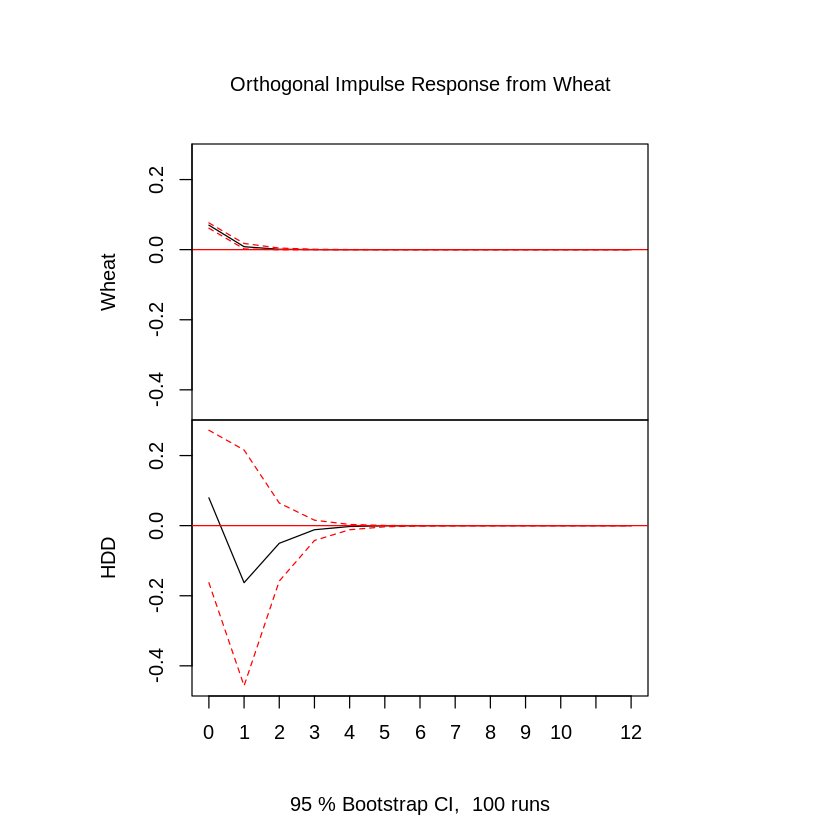

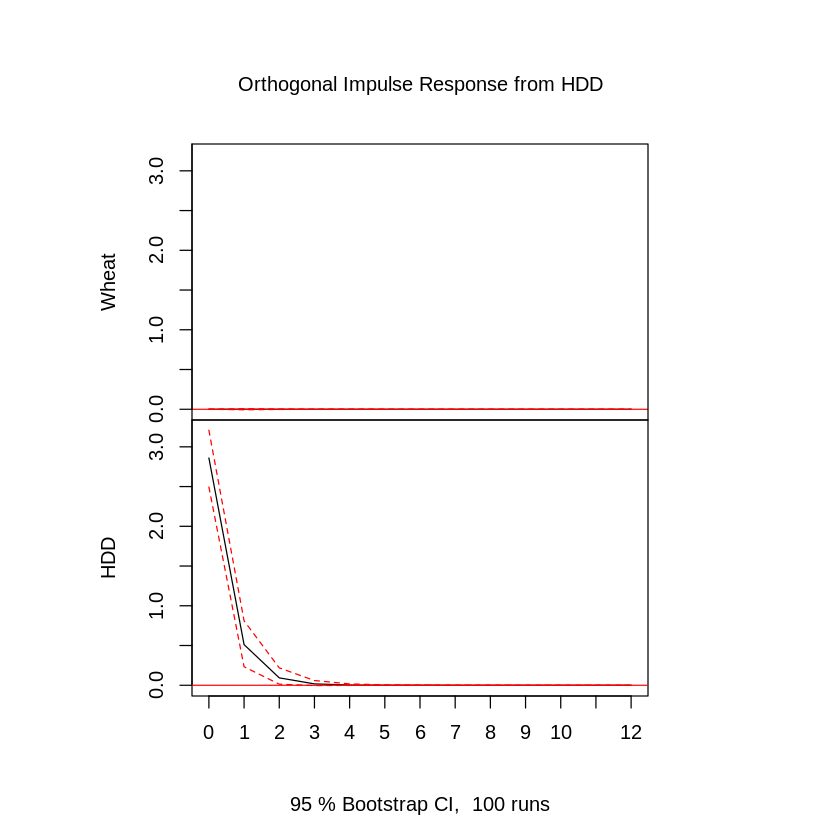

In [ ]:
irf<-irf(var.1lag,n.ahead = 12,ortho = TRUE,ci=0.95)
plot(irf)

Effet d'un choc sur le cours du blé :
* un effet immédiat, négatif et significatif sur le nombre de HDD jusqu'au troisième trimestre.
* un effet immédiat, négatif et peu significatif sur le cours du blé.

Effet d'un choc sur le nombre de HDD :
* pas d'impact sur le cours du blé contre toute attente
* un effet positif, immédiat et très significatif sur le nombre de HDD jusqu'au troisième trimestre.

Nous faisons le constat décevant que les résultats vont tous à l'encontre de nos prédictions.\
Nous ne pouvons donc pas conclure que les températures extrêmes aux Etats-Unis impactent significativement le cours du blé.

En revanche, les résultats indiquent que le cours du blé semble avoir un impact sur la météo. Ceci semble impossible: comment un prix peut-il influencer un phénomène naturel ?
Cependant, il y a une autre explication possible. Effectivement, les calculs des prix sur les marchés sont de plus en plus complexes et prennent en considération de nombreux éléments, notamment la météo. Il est très probable que les financiers utilisent des estimations très pointues de températures futures pour fixer les prix, ainsi ils ont un "temps d'avance" sur la météo, et ne prennent alors pas en comptent les températures passées mais futures. Ce phénomène fausse nos tests et les amène à comprendre que le prix du blé a un impact sur la météo.


**Estimation des IRF (Impulse Response Function) par les projections locales**

On estime les IRF par la méthode des projections locales. On spécifie les paramètres suivants :

* Le nombre d'horizon est égal à 12
* Pour chaque horizon $h = 1, ..., 12$ , le nombre de retards dans la régression de la projection locale sera au plus égal à 8 (max_lags = 8) et choisi par la minimisation du critère BIC
* On applique des chocs égaux à 1 écart type du choc structurel : shock_type = 0. (shock_type =1 pour des chocs )
* Intervalle de confiance à 95% (confit=1.96) (confit = 1.65 pour un intervalle de confiance à 90% et confit=1 pour un intervalle de confiance à 68%)

[[1]]
NULL


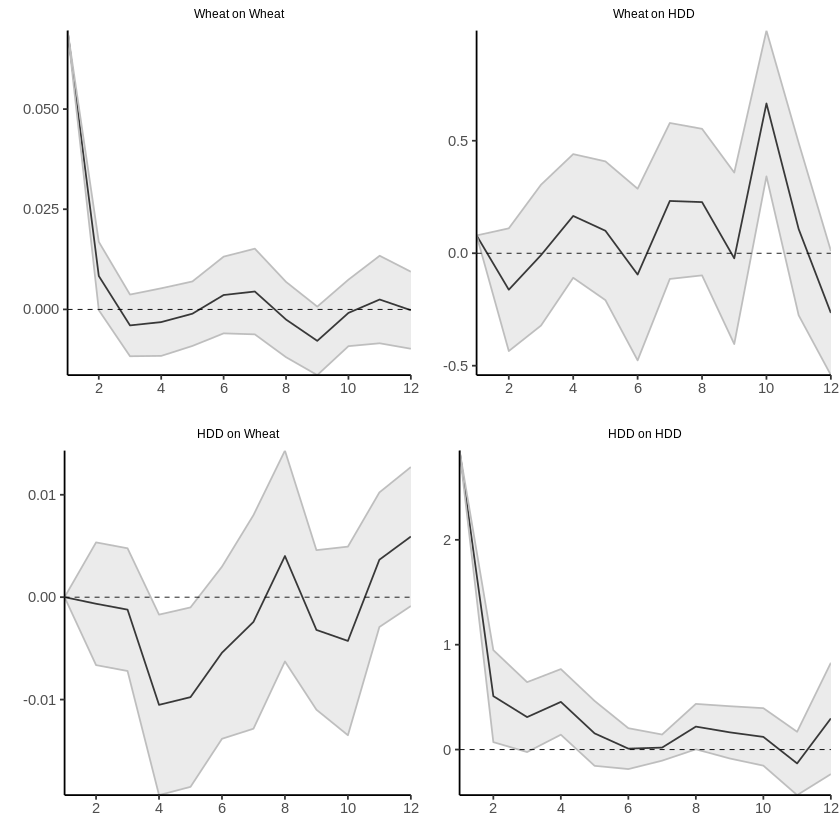

In [ ]:
library(lpirfs)
irf_LP <-lp_lin(endog_data = df_merged[, c('Wheat', 'HDD')],
                    lags_endog_lin = NaN,
                    lags_criterion = 'BIC',
                    max_lags = 8,
                    trend = 0,
                    shock_type = 0,
                    confint=1.96,
                    hor=12,
                    adjust_se=TRUE)

plot(irf_LP)

Ici, on étudie la fonction d'impulsion réponse sans utiliser le modèle VAR mais en prenant en compte uniquement les données.
Les résultats sont rès différent de ceux obtenus avec ceux obtenus à l'aide de la fonction *irf* de R qui utilise le VAR(1) précedemment déterminé.
Les réactions face aux chocs sont bien plus significatives.\
On observe alors que qu'un choc sur les HDD a un effet négatif et persistant sur le prix du blé (cf graphique en bas à gauche), en revanche l'effet d'un choc du cours du blé sur les HDD est assez étonnant. En effet, on observe une réaction qui oscille à peu près autour de zéro mais qui, à  terme, est négative.



##9. Test de cointégration

Par définition, des séries sont dites cointégrées si et seulement si elle sont intégrées à un ordre d (d>0) et qu’il existe au moins une combinaison linéaire de ces séries avec des séries d’ordre d’intégration strictement inférieur à d. Dans notre étude, les séries n’ont pas le même ordre d’intégration puisque la série des HDD est stationnaire et n’a pas eu besoin d’être différenciée alors que la série du cours du blé a été différencié une fois.\
Comme une des séries est I(0), on en déduit que nos séries de peuvent pas être cointégrées.\
Ainsi, nous ne pouvons pas faire de test de cointégration de Granger ou de Johansen.

# Conclusion générale


Nous avons étudié les séries temporelles du prix du blé et du nombre de heating degree days (HDD) sur une période de 22 ans, de 2000 à 2022.\
Le but de notre étude était de déterminer l’impact que pouvait avoir une hausse de la récurrence de températures extrêmes sur le prix du blé, et s’il y avait une corrélation entre ces deux données.

Nous avions vraiment à coeur de travailler sur un sujet qui mentionne une problématique réelle et urgente: le dérèglement climatique. Effectivement, les HDD sont un bon moyen de mesurer les écarts de température extrêmes, à partir d'un point de référence, qui correspond ici à environ 18°C. Puis, nous voulions étudier la possibilité que celle-ci ait un lien avec le prix des ressources. Les méchanismes de prix classiques nous permettent de comprendre rapidement comment les deux pourraient être corrélés: si la production de blé est réduite de par des mauvaises récoltes, alors le prix se verra augmenté, face à une demande constante, voire en augmentation (dû au la croissance de la population).
\
Pour commencer, nous avons étudié les autocorrélogrammes simples et partiels de nos variables. Nous en avons conjecturé grâce aux représentations graphiques que la série du blé pouvait suivre un modèle AR(2) et celle des HDD un modèle ARMA(3,2).\
Par la suite, nous avons étudié les tests ADF, KPSS et PP de ces données. Ces tests nous ont permis de conclure sur la stationnarité de la série des HDD et sur la présence d’une racine unitaire dans la série du blé. De plus, nous avons remarqué que la série du blé était une marche aléatoire, ce qui est pertinent puisque c'est une série financière. Sa nature de marche aléatoire rejoint l'hypothèse des marchés efficients, c'est-à-dire la défition du cours d'un actif est un phénomène avant tout stochastique, donc en réalité imprévisible. Face à ces résultats, nous avons appliqué le principe de différenciation sur les données du prix du blé afin de pouvoir les manipuler dans la suite de notre étude comme étant une série stationnaire.\
À partir de ce moment, nous pouvions estimer un modèle VAR(1) afin de procéder à une analyse multivariée. Le modèle VAR, permet une analyse à court terme de séries multivariées. À l'aide de ce modèle et du test de Granger, nous avons pu conclure qu’aucune variable n’avait d’effet causal significatif sur l’autre, autrement dit que les deux variables étaient exogènes l'une par rapport à l’autre.\
Enfin, puisque la série sur les HDD était stationnaire dès le départ, nous n’avons pas pu faire de test de cointégration de Johansen, qui correspond à une analyse à plus long terme que celle possible grâce au modèle VAR.\
\
En choisissant nos données, nous nous attendions à ce qu’il y ait une corrélation assez forte entre le cours du blé et les variations de températures quantifiées par les HDD.

Seulement, ce n’est pas ce que permet de conclure notre étude sur ces séries. Elle ne trouve pas de causalité évidente entre les deux.

Or, il existe une explication assez rationnelle à cela. Effectivement, nous avons choisi de concentrer nos données sur les HDD de l’Etat du Kansas, afin de simplifier l'importation et l'étude des données. Cependant, le Kansas n'est pas l’unique producteur de blé au monde. Il demeure l'un des plus gros producteurs aux Etats-Unis, mais le pays en lui-même n'est pas numéro un. Par exemple, il aurait été très intéressant de prendre en compte les données Russes sur les HDD, car ils font partie des plus gros exportateurs de blé.\
Les données Russes étant moins accessibles gratuitement et facilement en ligne, nous avons du nous limiter, quitte à obtenir des résultats moins concluants. Cela peut être la raison de l’absence de causalité entre nos séries car les prix sur le marché des matières premières est déterminé par l’offre et la demande, et que nos données météorologiques n’affectent qu’une petite partie de l’offre.\
On peut alors se demander si le résultat aurait été différent en faisant une étude plus complexe, qui aurait pris en compte l’ensemble des acteurs économiques du côté de l’offre.\
\
En plus des limites de notre étude, au vu du réchauffement climatique, du dérèglement des saisons et l’augmentation de phénomènes météorologiques extrêmes, le monde va devoir faire face à de réelles difficultés en terme de production agroalimentaire.\
On peut facilement émettre l’hypothèse que cela va se refléter sur les prix à partir certain niveau de volatilité des températures.\
En effet, les pratiques agricoles actuelles, bien qu’elles soient de plus en plus innovantes, ne sont pas encore au point en matière de développement durable, et d’adaptabilité aux climats de plus en plus instables.

#Annexe : Test de détection de bulles spéculatives sur le prix du blé


À l'origine nous nous intéressions au prix du blé car il s'agit d'une matière première au coeur de nombreuses cultures, et l'alimentation représente une part importante du budget de la majorité des foyers. Les Européens, par exemple, allouent en moyenne 14.8% de leur revenu à l'alimentaire, et allant jusqu'à 28% pour la Roumanie.

Dans les graphiques précedents, nous remarquons que le maximum de la courbe a été atteint en 2008, correspondant au début de la crise alimentaire, qui a eu lieu à peu près au même moment que celle des subprimes.
En effet, suite à cette crise le nombre de personnes souffrant d’insécurité alimentaire$^*$ dans le monde est monté à un milliard, un triste record. Cette insécurité était en lien direct avec la hausse des prix des matières premières.

La civilisation humaine est relativement habituée à ce que sa sécurité alimentaire puisse être menacée par des phénomènes naturels (crise des pommes de terres en Irlande au début du 20e siècle, disettes et famines dues au mauvaises récoltes au Moyen-Age).
Avec l'effet de la crise de 2008 sur le secteur des matières premières, on sait que la sécurité alimentaire peut également dépendre des marchés. Il peut donc devenir intéressant (voire vital) de pouvoir détecter d'éventuelles bulles spéculatives sur le prix de ces matières premières afin de les éviter.

*L’Organisation des Nations Unies pour l’alimentation et l’agriculture (FAO) reconnait l’état d’insécurité alimentaire lorsqu’une personne est dans l’incapacité de consommer de la nourriture en quantité suffisante, menacant sa vie ou ses moyens d’existence de manière immédiate.


En 2011, le Journal of International Money and Finance appliquait le test de PWY  à la détection de bulles spéculatives sur les marchés des matières premières. Pour cela, ils ont utilisé les prix des contrat futures de ces dernières, c'est-à-dire des prix à terme.

Dans le cadre de notre projet nous allons donc appiquer le test au prix du blé entre 2000 et 2022, car nous travaillons sur cette période.

##Installation des packages

In [ ]:
install.packages("exuber")
install.packages("MultipleBubbles")

##Test de détection de bulles spéculatives

On estime la régression ADF :
$$
x_{t} = \mu_{x} + \rho x_{t-1} + \sum_{j=1}^{p} \phi_{j} \Delta x_{t-j} + \varepsilon_{x,t}
$$
avec $\varepsilon_{x,t} \sim NID(0,\sigma^{2}_{x})$.\
\
On teste l'hypothèse nulle de racine unitaire contre l'hypothèse alternative d'une racine explosive. On a donc un test unilatéral du coté droit.\
\
$$\left\{ \begin{array}{c}
H_{0} : \rho =1 \Rightarrow \,racine\,unitaire\,(pas\ de\ bulle)\\
H_{1} : \rho>1\, \Rightarrow \,racine\,explosive\ (possible\ présence\ d\ 'une\ bulle)\
\end{array}\right.
$$
\
en faisant des régressions forward sur des fractions $r_{0} \leq r\leq 1$ des observations, on obtient la statistique\
\
$$SADF(r_{0})=\sup_{r \in [r_{0},1]} ADF_{r}$$
où $ADF = \frac{\hat{\rho}-1}{\hat{\sigma}_{\hat{\rho}}}$.\
\
Nouvelle règle de décision : rejet de $\mathrm{H_0}$ si $\mathrm{SADF(r_{0})}$ > VC, avec VC quantile d’ordre 1α.

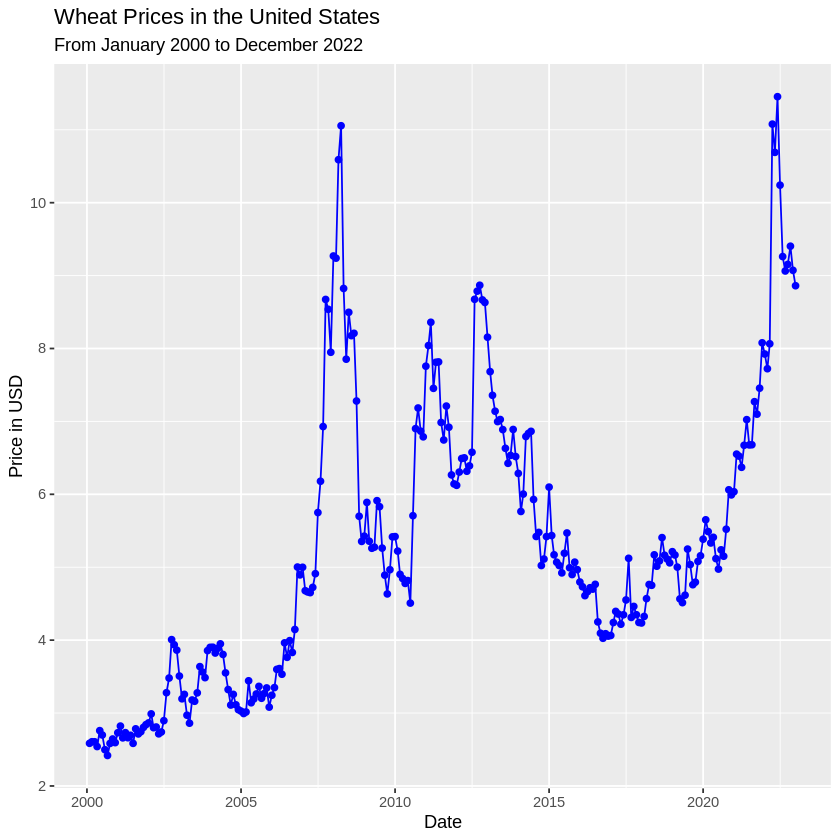

In [ ]:
#Rappel de la représentation graphique du cours du Blé 2000-2022
graph_wheat_data+labs(x = "Date", y = "Price in USD", title = "Wheat Prices in the United States", subtitle = "From January 2000 to December 2022")


####Test de bulle sur la période globale

In [ ]:
library(urca)
adf1<-ur.df(y = log(wheat_data_df$Price),type=c("drift"), lag=12, selectlags = c('AIC'))
summary(adf1)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.22366 -0.03661 -0.00697  0.03179  0.31916 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.04356    0.02092   2.082   0.0383 *
z.lag.1     -0.02448    0.01260  -1.943   0.0531 .
z.diff.lag   0.13411    0.06141   2.184   0.0299 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07016 on 260 degrees of freedom
Multiple R-squared:  0.02905,	Adjusted R-squared:  0.02158 
F-statistic:  3.89 on 2 and 260 DF,  p-value: 0.02166


Value of test-statistic is: -1.9426 2.2696 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.44 -2.87 -2.57
phi1  6.47  4.61  3.79


On commence par effectuer un test de Dickey-Fuller augmenté (ADF), avec constante mais sans tendance, dans le but de déterminer si la racine est explosive ou unitaire.\
On rappelle que l'interprétation se fait de telle sorte que :     
Lorsque $t_\rho < t$ on rejette $H_0$, avec t le seuil issu de la table de Dickey-Fuller et :
$$ t_{\hat{\rho}} = \frac{\hat{\rho}}{\sigma_\hat{\rho}} $$
avec $\sigma_\rho$ l'écart-type de $\hat{\rho}$.\
\
Le tableau renvoyé par le code nous donne : $t = -2.87$ pour une erreur de première espèce de 5% et $t_\rho = -1.9426$.\
On a alors $t_\rho > t$, ce qui signifie la conservation de l'hypothèse nulle. Nous somme donc en présence d'une racine unitaire, on retrouve le résultat de la sous-partie 3 de la partie 1.\
\
La présence d'une racine unitaire ne nous permet pas de conclure sur la présence d'une bulle spéculative. Pourtant, on s'attendait à la présence d'une bulle en 2008 suite à la crise financière.\
\
En effet, la puissance du test sur la période globale est réduit car lorsque les bulles éclatent, le prix revient brutalement vers sa moyenne. On peut alors faire un test de bulle sur des plages récursives pour contrer cet effet.

####Test de bulle sur des plages récursives

In [ ]:
library(exuber)
x<-log(wheat_data_df$Price)

radf_WP <-radf(x,lag=1)
sprintf("La statistique du test SADF est %f",radf_WP$sadf)
print(diagnostics(radf_WP,option = "sadf",))


Attaching package: ‘exuber’


The following object is masked from ‘package:rugarch’:

    report


The following objects are masked from ‘package:zoo’:

    index, index<-




[1] "La statistique du test SADF est 1.813946"

Using `radf_crit` for `cv`.




── Diagnostics (option = sadf) ────────────────────────────────── Monte Carlo ──

series1:  Rejects H0 at the 5% significance level



D'après nos résultats, on rejette l'hypothèse.

In [ ]:
date_bulle<-datestamp(radf_WP,option = "sadf",min_duration = psy_ds(x))
date_bulle

Using `radf_crit` for `cv`.



Start,Peak,End,Duration,Signal,Ongoing
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>
91,99,101,10,positive,FALSE


In [ ]:
print(wheat_data_df$Date[91])
print(wheat_data_df$Date[99])
print(wheat_data_df$Date[101])

[1] "2007-08-01"
[1] "2008-04-01"
[1] "2008-06-01"


Le cours du blé a donc connu une bulle spéculative. Selon nos résultats, cette bulle a commencé en août 2007, a connu son pic en avril 2008 et s'est éclatée en juin 2008.

Using `radf_crit` for `cv`.



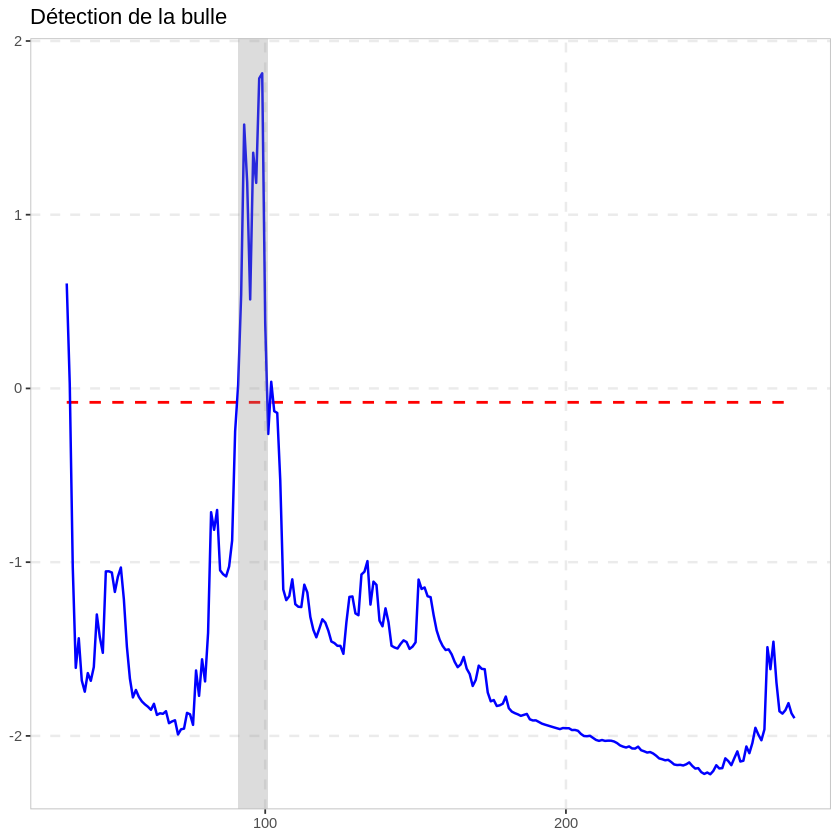

In [ ]:
#Graphique à améliorer
autoplot(radf_WP,option="sadf",min_duration = psy_ds(x))+labs(title="Détection de la bulle")

La zone grisée du graphique correspond à la période de la bulle spéculative, elle apparaît effectivement autour de 2008 et pour une durée du 10 mois selon nos résultats.\
La conclusion du test sur des plages récursives est donc bien plus pertinente que cette sur la période globale. En effet, avec ce type de test on retrouve bien la bulle spéculative qui a été observée à cette époque.

#**Bibliographie :**

* Partie 1 :
 * https://www.lesechos.fr/2007/12/les-cours-du-ble-etablissent-un-nouveau-sommet-historique-548156
 * https://www.lemonde.fr/international/article/2008/04/17/cinq-questions-sur-la-crise-alimentaire-mondiale_1034481_3210.html
 * https://www.lemonde.fr/planete/article/2012/08/13/la-secheresse-fait-flamber-les-prix-alimentaires_1745555_3244.html
 * https://www.eia.gov/energyexplained/units-and-calculators/degree-days.php#:~:text=Heating%20degree%20days%20(HDDs)%20are,for%20the%20two%2Dday%20period.
 * https://www.lafranceagricole.fr/conjoncture-cultures/article/843580/la-production-mondiale-de-ble-et-de-mais-revue-a-la-baisse#:~:text=La%20production%20de%20bl%C3%A9%20des,%C3%A9galement%20%C3%A0%2019%2C05%20millions.
 * https://ftp.cpc.ncep.noaa.gov/htdocs/degree_days/weighted/daily_data/
* Conclusion :
 * https://fr.statista.com/statistiques/550220/pays-exportateurs-de-ble-farine-de-ble-et-de-produits-de-ble-monde/#:~:text=La%20Turquie%20et%20l'Égypte,de%20tonnes%20pour%20la%20Turquie
* Annexe :
 * https://www.touteleurope.eu/societe/alimentation-quel-budget-pour-les-menages-europeens/#:~:text=Les%20Europ%C3%A9ens%20consacrent%20en%20moyenne,entre%20les%2027%20%C3%89tats%20membres
  * https://www.alumneye.fr/la-speculation-sur-les-matieres-premieres-une-menace-pour-la-securite-alimentaire-dans-le-monde/
